In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display #lets you show more than one df
import os
import multiprocessing as mp
import gc

plt.rc('font', size=22)          # controls default text sizes
plt.rc('figure',figsize = (15,10))

In [2]:
#configure this string as the directory to where you have the files.
dataDir = '/home/ubuntu/LCPB/data/'


## Data Structure

#### Folder set 1, f_MT: accretion efficiency (the fraction of mass lost from a primary star that can be accreted by a secondary star during a mass transfer episode).

In [3]:
f_MT= [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
0.95, 1]
#create same label as data
f_MT_lb = [str(x).replace('.', '') for x in f_MT]# lb for label

#### Sub folder, Alpha: common envelope efficiency

In [4]:
alpha = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
alpha_lb = [str(x) for x in alpha]

#### Files, split by  
data_BHBs_$*$.txt → files corresponding to binary black holes (BHBs)  
data_BHNS_$*$.txt → files corresponding to black hole – neutron star binaries 

$*$ indicates 12 different metallicities (Z) of the stellar progenitors of the binary compact objects.


In [5]:
#Metalicity
Z = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
Z_lb = [str(x) for x in Z]

#### Data 

* Column 0: identifier of the binary  
* Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun (1 Msun= 1.989e33 g). This is the initial mass of the most massive stellar progenitor.  
* Column 2: initial mass (ZAMS mass) of the secondary member of the binarysystem in Msun. This is the initial mass of the least massive stellar progenitor.    
* Column 3: mass of the compact object that forms from the primary member
(Msun)  
* Column 4: mass of the compact object that forms from the secondary member
(Msun)  
* Column 5: mass of the merger remnant of the two compact objects (Msun). In these simulations, it is just the sum of the masses of the two compact objects.
* Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two compact objects (in Gyr = 1e9 yr)
* Column 7: semi-major axis of the binary system at the formation of the second-born compact object (in solar radii, Rsun = 6.96e10 cm)
* Column 8: orbital eccentricity of the binary system at the formation of the second-born compact object.

## Insert parquet code
include the code jake used to make the parquete data file and explain the optimisation this achieved and the reasons is was necessary. Postentially briefly explain the other options considered, dask, spark, chunking.

In [6]:
#unit dictionary
units = {
    'ZAMS' : 'Msun',
    'comp' : 'Msun',
    'merge' : 'Msun',
    't_delay' : 'Gyr',
    'smj_axis' : 'Rsun',
}

#you must select desired columns using the column names in a list. 
#you can take a random subset by selecting the number of BBH you want or the fraction of the total data
#set the default directory to where you have the parquet file
def getData(col = ['m_ZAMS_1', 'm_ZMAS_2', 'm_comp_1', 'm_comp_2', 'm_merge', 't_delay', 'smj_axis', 'alpha', 'f_MT', 'Z','orb_ecc']
            , rRows = 0, dataFraction = 1, dataDir = '~/LCPB/all_BHBs.parquet',seed = None):
    if (dataFraction != 1):
        rRows = int(dataFraction*87756770)
    if (rRows == 0):
        return pd.read_parquet(dataDir, columns = col)
    elif (rRows > 0):
        rand = np.random.default_rng(seed = seed)
        rows_selected = rand.integers(low = 0, high = 87756770, size = rRows)
        concf = pd.DataFrame()
        for col_i in col:
            onecol = pd.read_parquet(dataDir, columns = [col_i]).iloc[rows_selected]
            concf = pd.concat([concf, onecol], axis=1)
            del(onecol)
            gc.collect()
        return concf

#examples
#df = getData(dataFraction=0.1,seed = 12345) #returns all columns but only a random 10% of the rows, with an inputted seed.
#df2 = getData(col = ['m_ZAMS_1','m_ZAMS_2','orb_ecc','m_merge','t_delay'],rRows=5)#returns two selected colums and only 5 random binary systems

In [7]:
def plotFrequency(df,prop):
    figalot = plt.figure(figsize=(15,10))
    plt.hist(df[prop], bins = 10000)
    plt.title('Binary Black Hole Systems, 10000 bins')
    plt.xlabel(prop)
    plt.ylabel('Frequency')

    fig100 = plt.figure(figsize=(15,10))
    plt.hist(df[prop], bins = 100)
    plt.title('Binary Black Hole Systems, 100 bins')
    plt.xlabel(prop)
    plt.ylabel('Frequency')

    fig30 = plt.figure(figsize=(15,10))
    plt.hist(df[prop], bins = 30)
    plt.title('Binary Black Hole Systems, 30 bins')
    plt.xlabel(prop)
    plt.ylabel('Frequency')

    fig10 = plt.figure(figsize=(15,10))
    plt.hist(df[prop], bins = 10)
    plt.title('Binary Black Hole Systems, 10 bins')
    plt.xlabel(prop)
    plt.ylabel('Frequency')

def plotMedian(df,prop,xlab = None):
    def lowerQuartile(stuff):
        return np.quantile(stuff,0.25)
    def upperQuartile(stuff):
        return np.quantile(stuff,0.75)

    med = df.groupby(prop)['t_delay'].agg('median').reset_index()
    lq = df.groupby(prop)['t_delay'].agg(lowerQuartile).reset_index()
    uq = df.groupby(prop)['t_delay'].agg(upperQuartile).reset_index()
    med.columns = [prop, 'median_t_delay']

    med['lower_quartile'] = lq['t_delay']
    med['upper_quartile'] = uq['t_delay']
    
    figAcc = plt.figure(figsize=(20,10))
    plt.plot(med[prop],med['median_t_delay'],label = 'Median')
    plt.xlabel(prop)
    if(xlab != None):
        plt.xticks(ticks = np.sort(np.unique(med[prop])),lables = xlab)
        
    plt.ylabel('Time Delay '+units['t_delay'])
    plt.title('Binary Black Hole Systems')
    plt.fill_between(med[prop], med['lower_quartile'], med['upper_quartile'], alpha=0.4, color='darkorange',label = 'Interquartile Range')
    plt.legend()
    return med

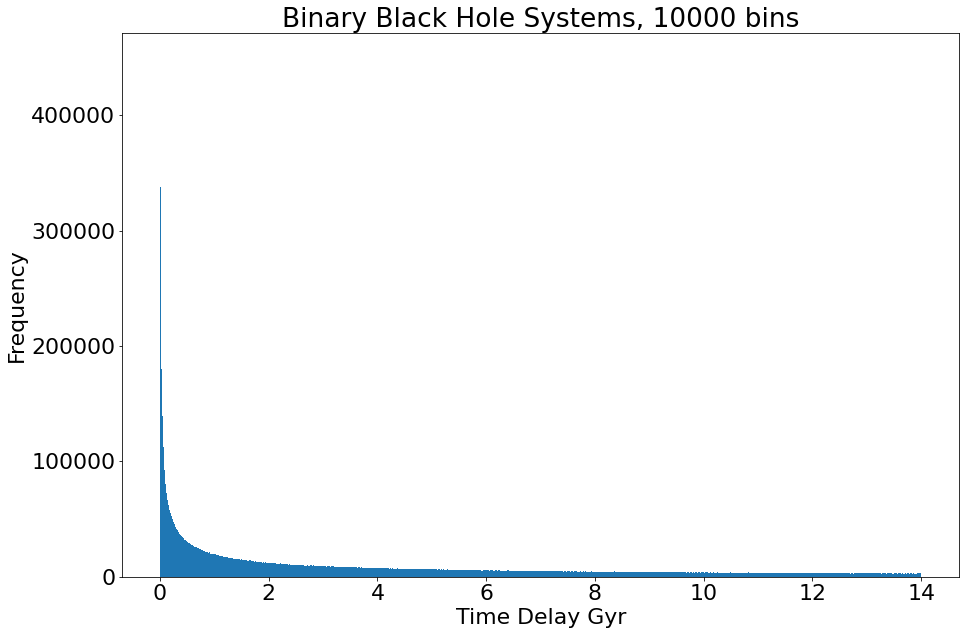

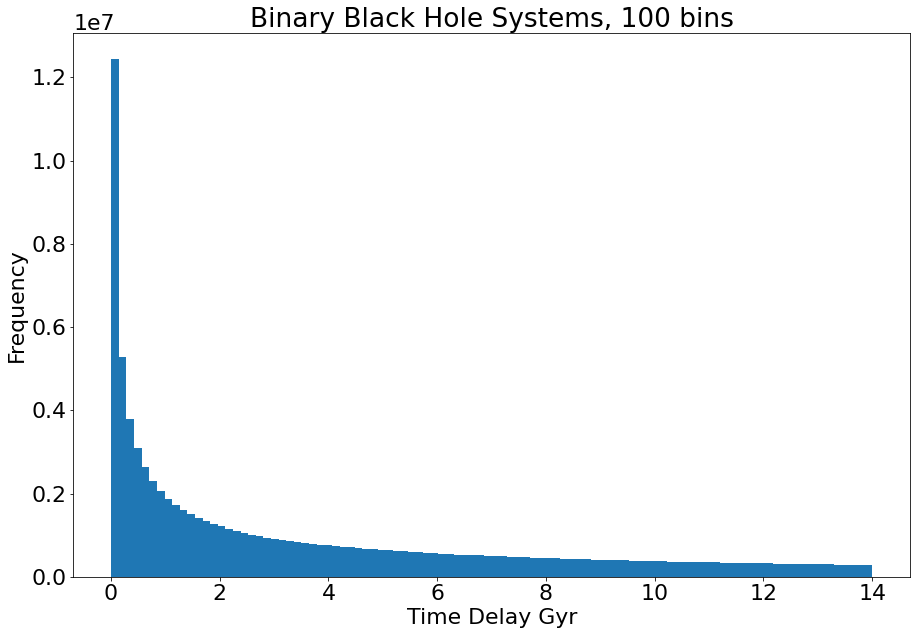

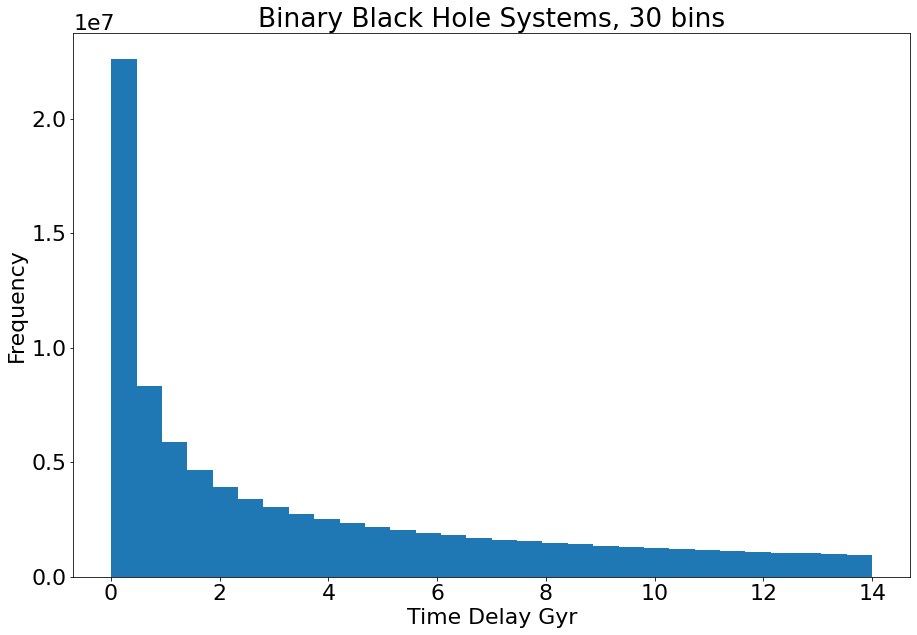

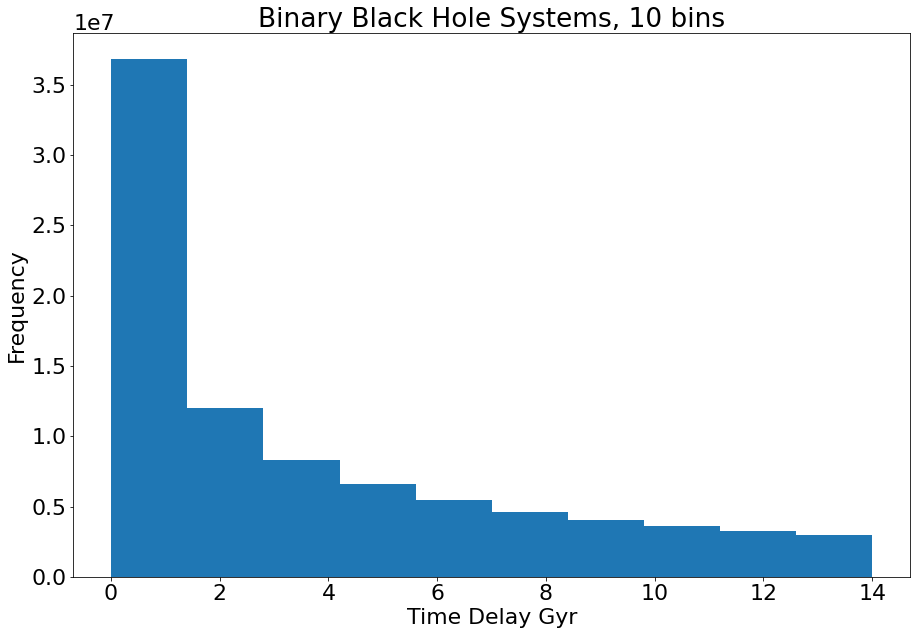

In [8]:
t_delay = getData(col = ['t_delay'])
t_delay.columns = ['Time Delay Gyr']
plotFrequency(t_delay,'Time Delay Gyr')

# Accretion Efficiancy

<BarContainer object of 20 artists>

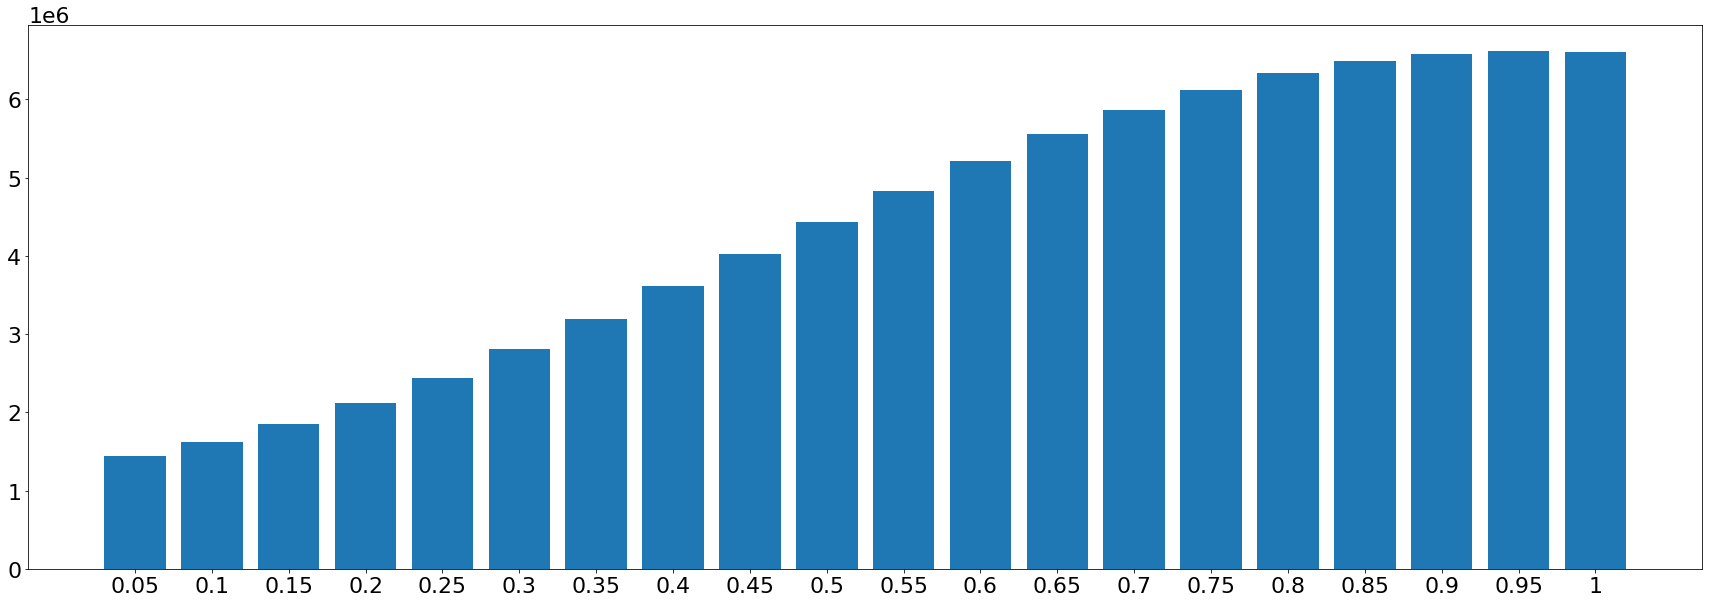

In [9]:
# Accretion Efficiency f_MT, getting the data
df = getData(col = ['f_MT','t_delay'])
df = df.rename(columns = {'f_MT':'Accretion Efficiency'})

frequency = df.groupby('Accretion Efficiency').agg('count').reset_index()
frequency = frequency.rename(columns = {'t_delay':'frequency'})
frequency
figfreq = plt.figure(figsize = (30,10))
plt.bar(frequency['Accretion Efficiency'],frequency['frequency'])

,Accretion Efficiency,median_t_delay,lower_quartile,upper_quartile
0,0.05,1.995949,0.467149,5.782688
1,0.1,1.991633,0.462488,5.803127
2,0.15,2.008681,0.457542,5.932697
3,0.2,2.136145,0.470302,6.228651
4,0.25,2.278570,0.487686,6.473514
5,0.3,2.376820,0.502852,6.590277
6,0.35,2.405806,0.508072,6.618817
7,0.4,2.433011,0.512004,6.682508
8,0.45,2.435796,0.505968,6.669694
9,0.5,2.421610,0.498481,6.611126


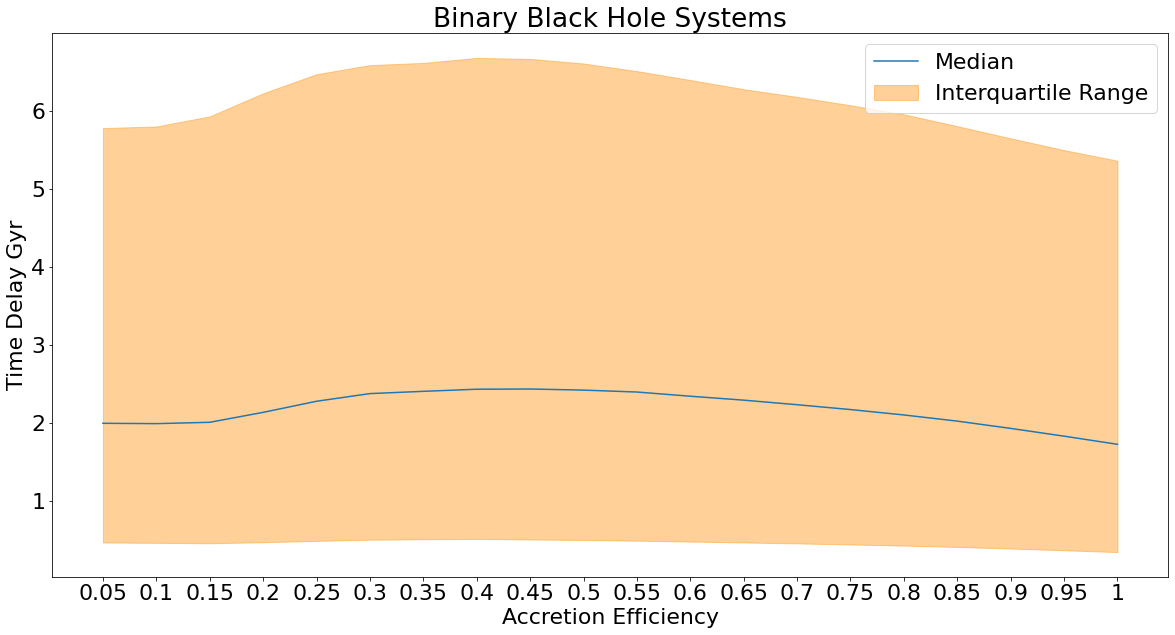

In [10]:
median = plotMedian(df,'Accretion Efficiency')
median

# Common Envalope Efficiancy

<BarContainer object of 11 artists>

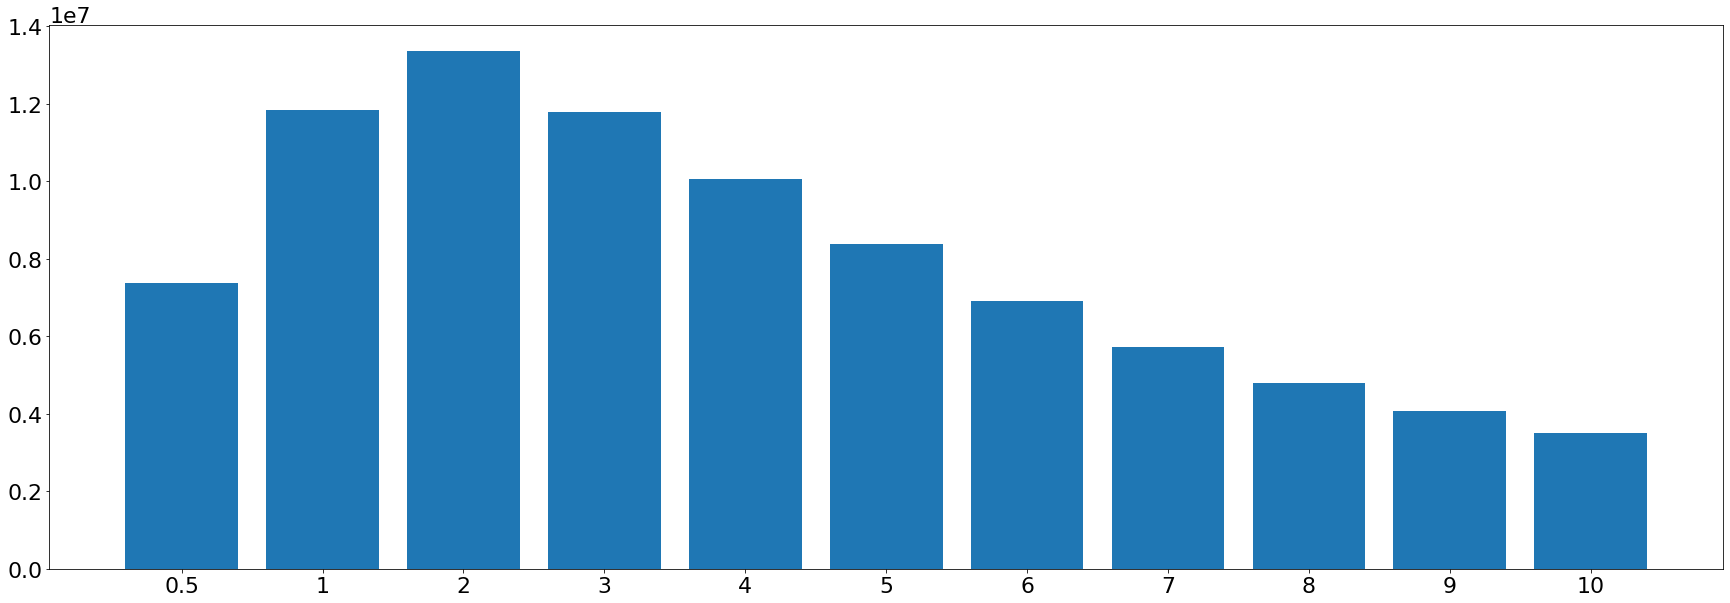

In [11]:
df = getData(col = ['alpha','t_delay'])
df = df.rename(columns = {'alpha':'Common Envalope Efficiancy'})

frequency = df.groupby('Common Envalope Efficiancy').agg('count').reset_index()
frequency = frequency.rename(columns = {'t_delay':'frequency'})
frequency
figfreq = plt.figure(figsize = (30,10))
plt.bar(frequency['Common Envalope Efficiancy'],frequency['frequency'])


,Common Envalope Efficiancy,median_t_delay,lower_quartile,upper_quartile
0,0.5,0.146489,0.035110,1.266774
1,1,0.466766,0.085272,2.125355
2,2,0.992626,0.198484,4.162977
3,3,1.572296,0.395511,4.930109
4,4,2.381117,0.709667,6.082266
5,5,3.195379,1.113011,7.071482
6,6,3.903664,1.550487,7.812633
7,7,4.540015,2.012089,8.356999
8,8,5.096031,2.475868,8.827353
9,9,5.572452,2.898868,9.206837


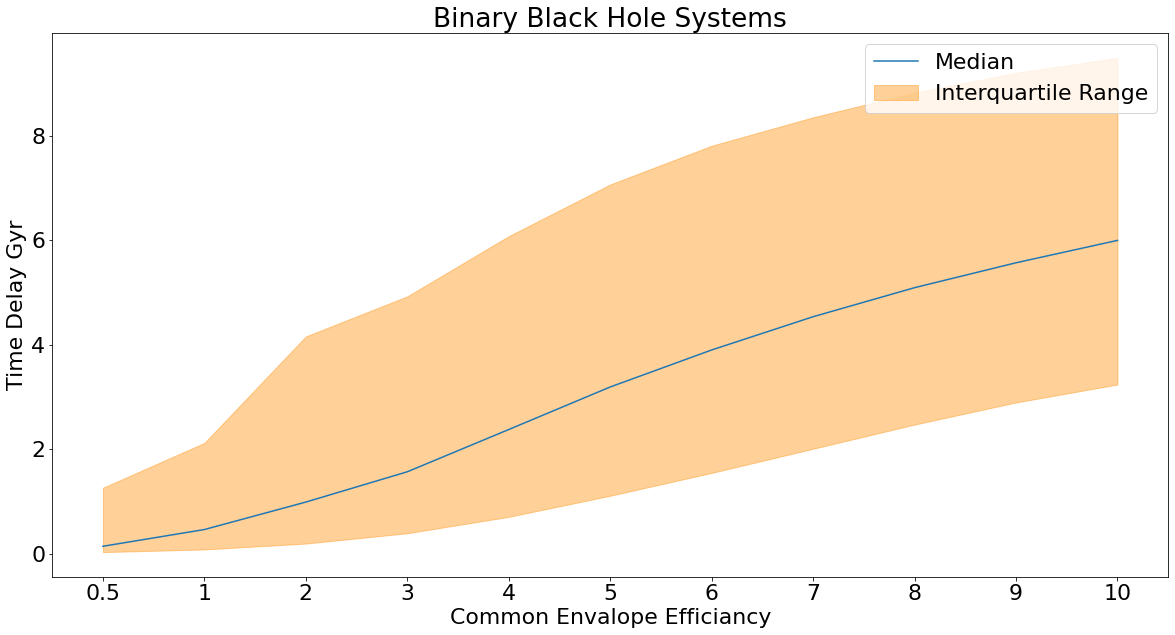

In [12]:
median = plotMedian(df,'Common Envalope Efficiancy')
median

# Metalicity

<BarContainer object of 12 artists>

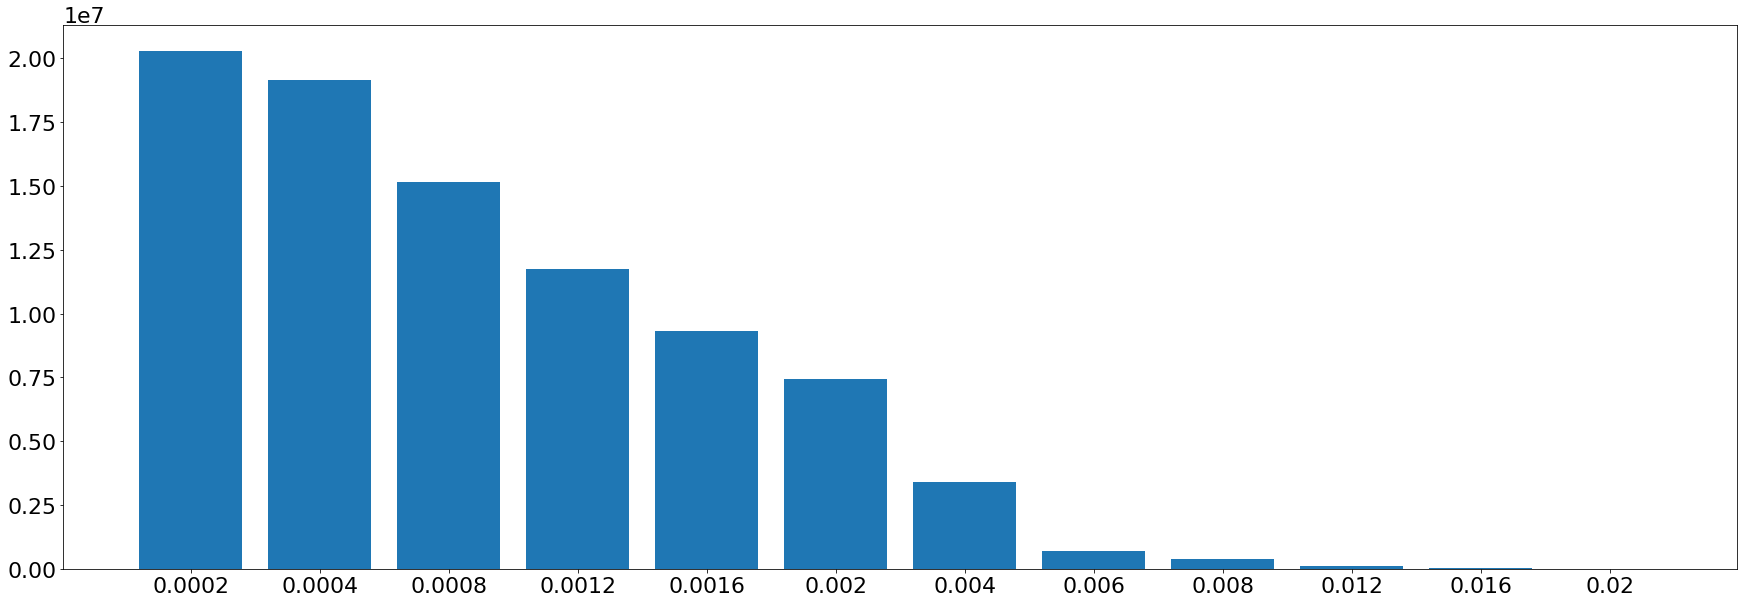

In [13]:
df = getData(col = ['Z','t_delay'])
df = df.rename(columns = {'Z':'Metalicity'})

frequency = df.groupby('Metalicity').agg('count').reset_index()
frequency = frequency.rename(columns = {'t_delay':'frequency'})
frequency
figfreq = plt.figure(figsize = (30,10))
plt.bar(frequency['Metalicity'],frequency['frequency'])

,Metalicity,median_t_delay,lower_quartile,upper_quartile
0,0.0002,1.741538,0.380066,5.160981
1,0.0004,1.991383,0.422104,5.630425
2,0.0008,2.352511,0.479996,6.389658
3,0.0012,2.451532,0.486995,6.674580
4,0.0016,2.401452,0.449581,6.677773
5,0.002,2.361548,0.453396,6.646560
6,0.004,2.935813,0.590829,7.698203
7,0.006,2.528598,0.668609,7.245487
8,0.008,2.482135,0.612524,6.253724
9,0.012,4.694326,1.376787,8.645225


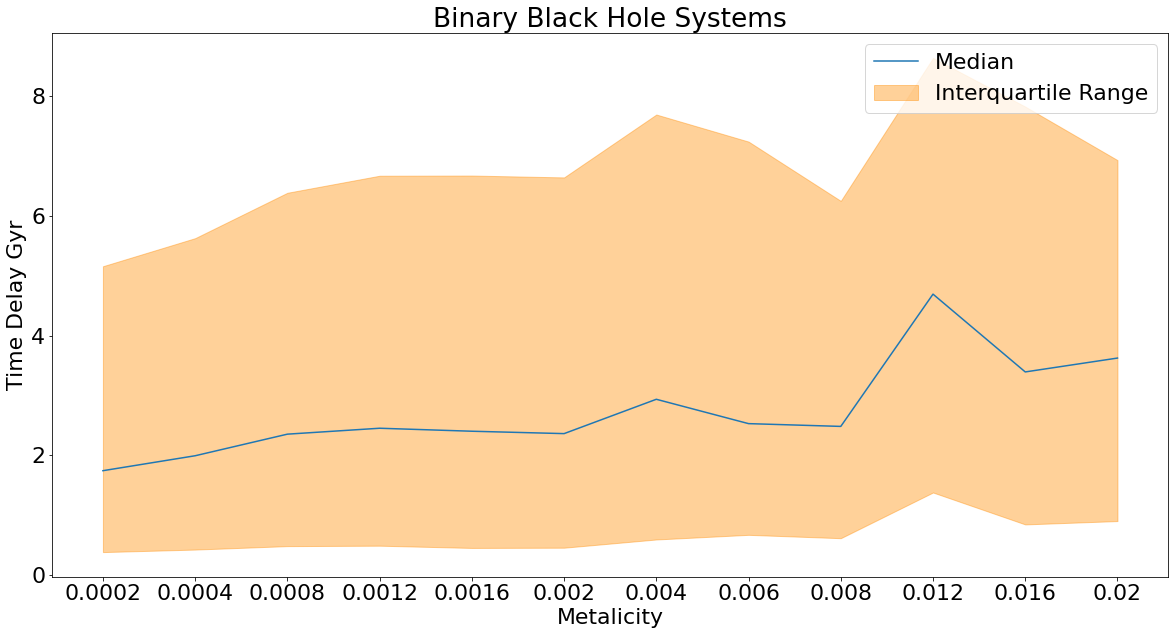

In [14]:
median = plotMedian(df,'Metalicity')
median

In [16]:
#Another median plot more tailored to the continuous properties. 
def plotMedianMass(df,prop,nbins = 30):
    
    # group the masses into quantiles and get the bins
    quantile, bins = pd.qcut(df[prop], q = nbins, retbins = True)
    # make the x axis lables with the bins
    xlab = [str(np.around(b,1)) for b in bins]
    xlabr = []
    for i in range(len(xlab)):
        if i == len(xlab)-1:break
        xlabr.append(xlab[i]+" - "+xlab[i+1])
    
    prop = prop + ', quantiles'
    # add the quantiles to the data frame
    df[prop] = quantile

    def lowerQuartile(stuff):
        return np.quantile(stuff,0.25)
    def upperQuartile(stuff):
        return np.quantile(stuff,0.75)
    
    med = df.groupby(prop)['t_delay'].agg('median').reset_index()
    lq = df.groupby(prop)['t_delay'].agg(lowerQuartile).reset_index()
    uq = df.groupby(prop)['t_delay'].agg(upperQuartile).reset_index()
    med.columns = [prop, 'median_t_delay']
    
    
    
    med['lower_quartile'] = lq['t_delay']
    med['upper_quartile'] = uq['t_delay']
    figAcc = plt.figure(figsize = (20,10))
    x = range(0,len(med))
    plt.plot(x,med['median_t_delay'],label = 'Median', marker = '.')
    plt.xlabel(prop)
    
    plt.xticks(ticks = x,labels = xlabr, rotation = 90)
        
    plt.ylabel('Time Delay '+units['t_delay'])
    plt.title('Binary Black Hole Systems')
    plt.fill_between(x, med['lower_quartile'], med['upper_quartile'], alpha=0.4,              color='darkorange',label = 'Interquartile Range')
    plt.legend()
    return med

# ZAMS Mass of Primary Object
The ZAMS is the mass of a gas when it starts to burn hydrogen and become a star. The primary object is the more massive of the two.

In [ ]:
df = getData(['m_ZAMS_1','t_delay'])
df.columns = ['ZAMS of Primary Object, Msun','t_delay']

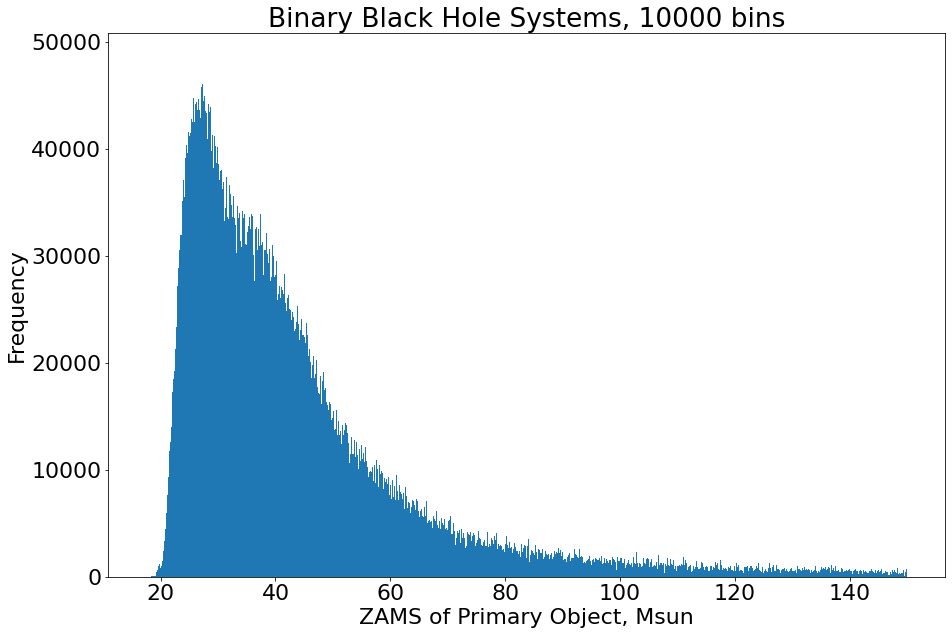

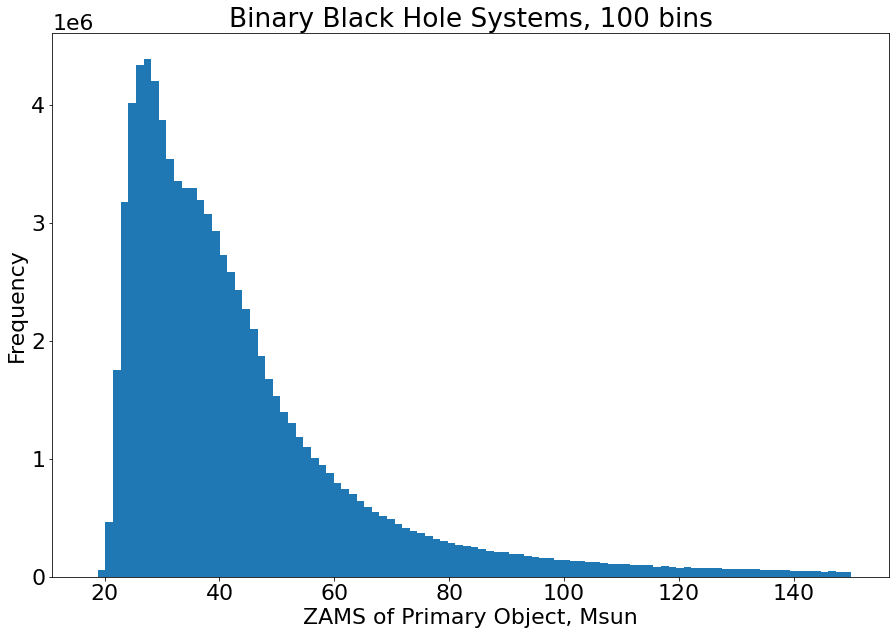

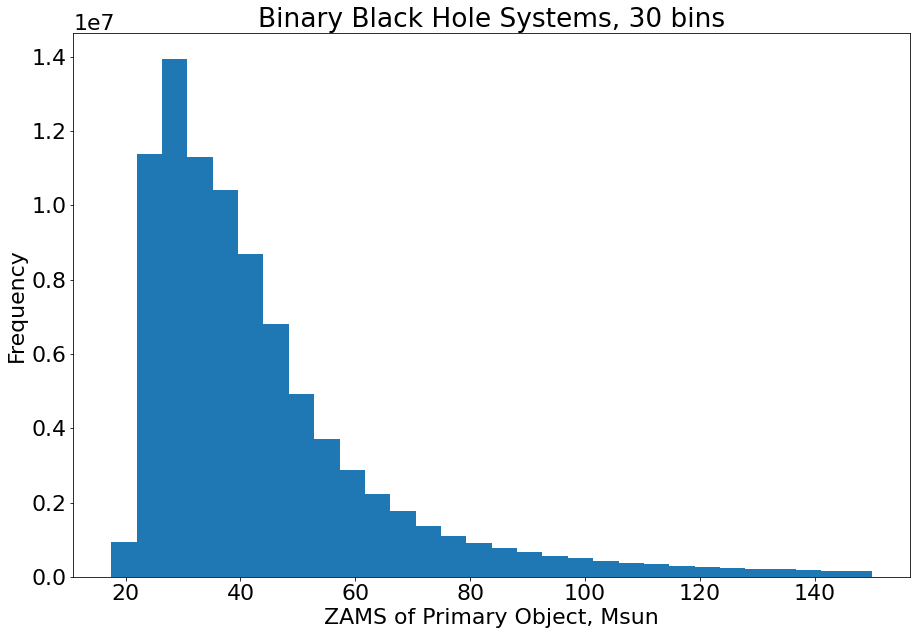

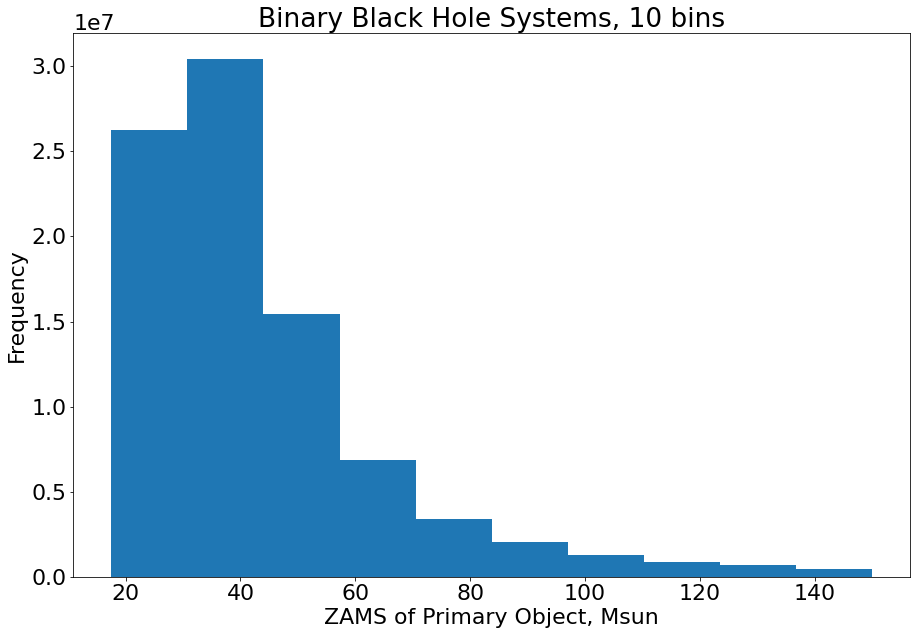

In [22]:
plotFrequency(df,'ZAMS of Primary Object, Msun')

,"ZAMS of Primary Object, Msun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(17.497999999999998, 23.115]",2.582282,0.778816,6.380171
1,"(23.115, 24.264]",2.282225,0.650129,5.978714
2,"(24.264, 25.233]",2.186965,0.600231,5.869976
3,"(25.233, 26.143]",2.119833,0.559137,5.817937
4,"(26.143, 27.021]",2.078199,0.523296,5.794375
5,"(27.021, 27.905]",2.031575,0.492109,5.761438
6,"(27.905, 28.802]",1.986725,0.462613,5.726428
7,"(28.802, 29.757]",1.938782,0.435341,5.695883
8,"(29.757, 30.771]",1.873501,0.401114,5.637024
9,"(30.771, 31.859]",1.797015,0.370627,5.535927


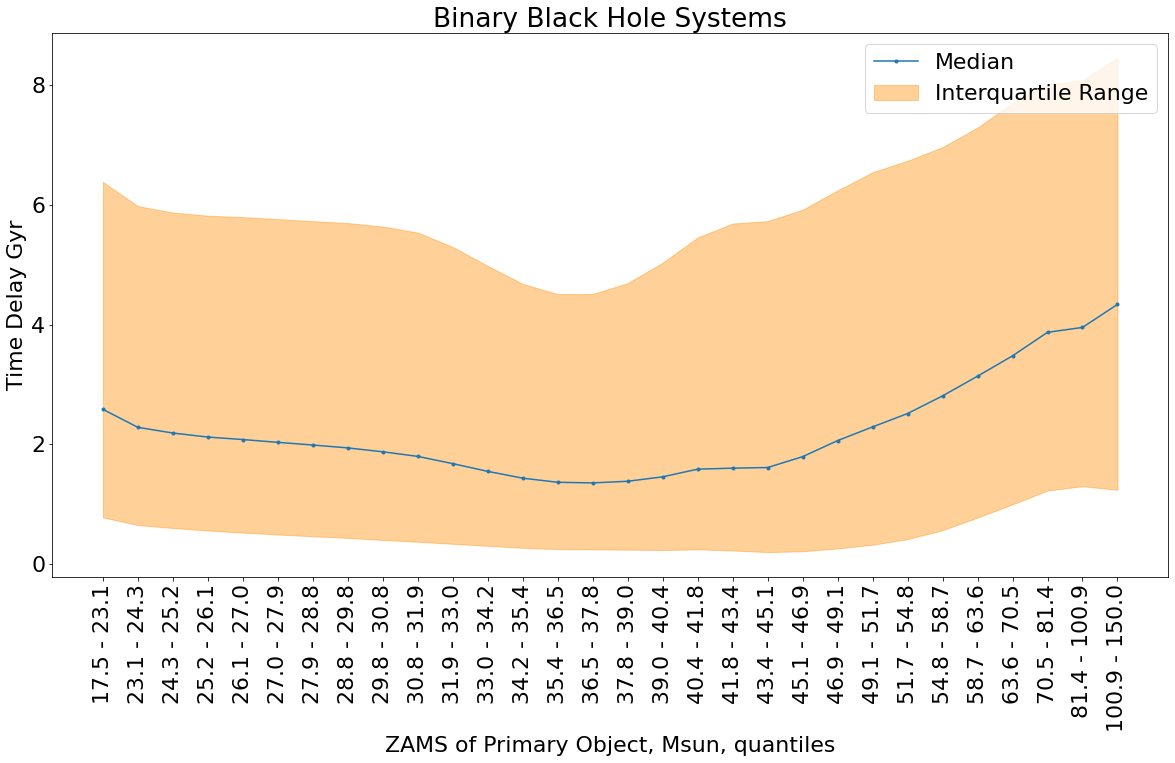

In [23]:
plotMedianMass(df,'ZAMS of Primary Object, Msun')

# ZAMS Mass of Secondary Object

In [24]:
df = getData(['m_ZAMS_2','t_delay'])
df.columns = ['ZAMS of Secondary Object, Msun','t_delay']

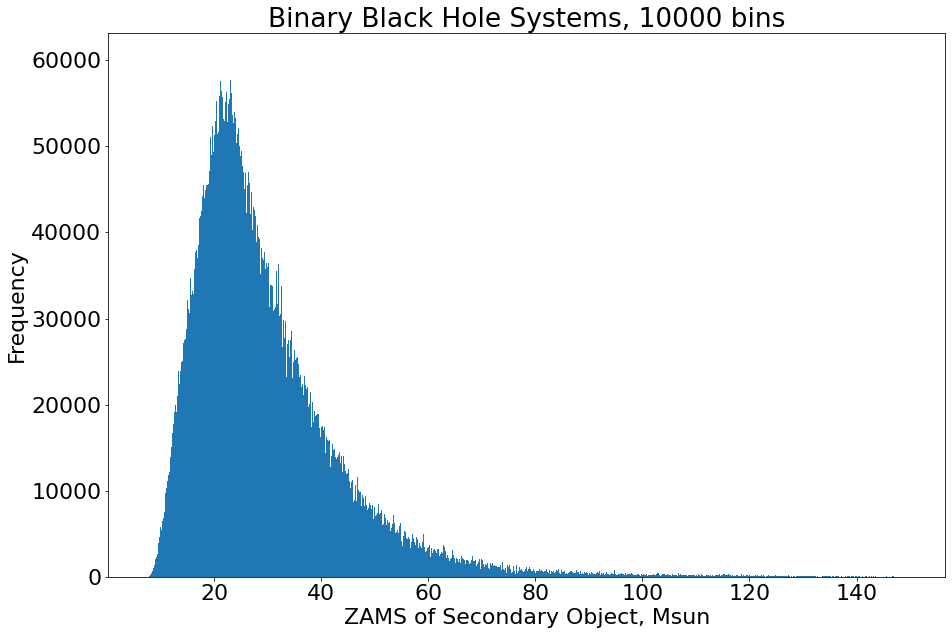

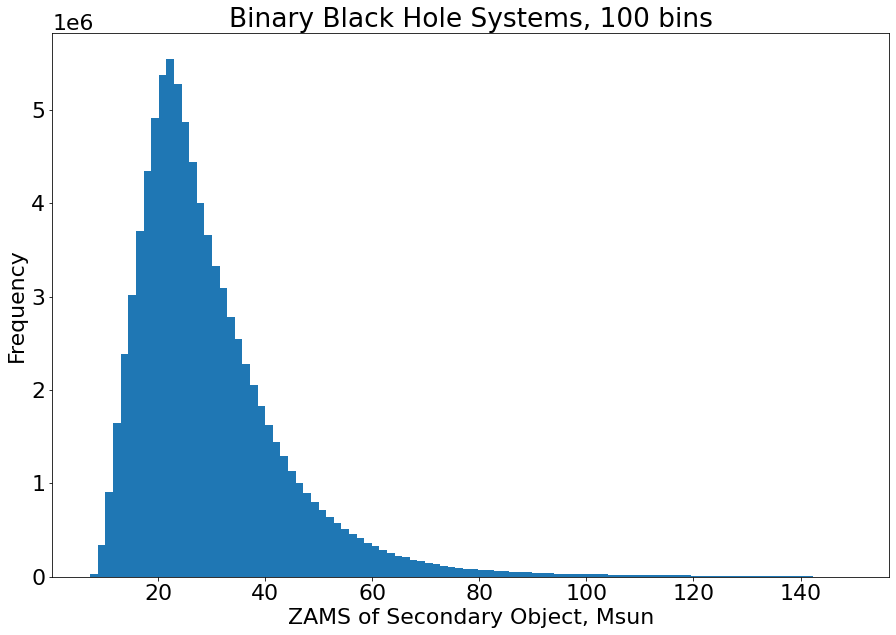

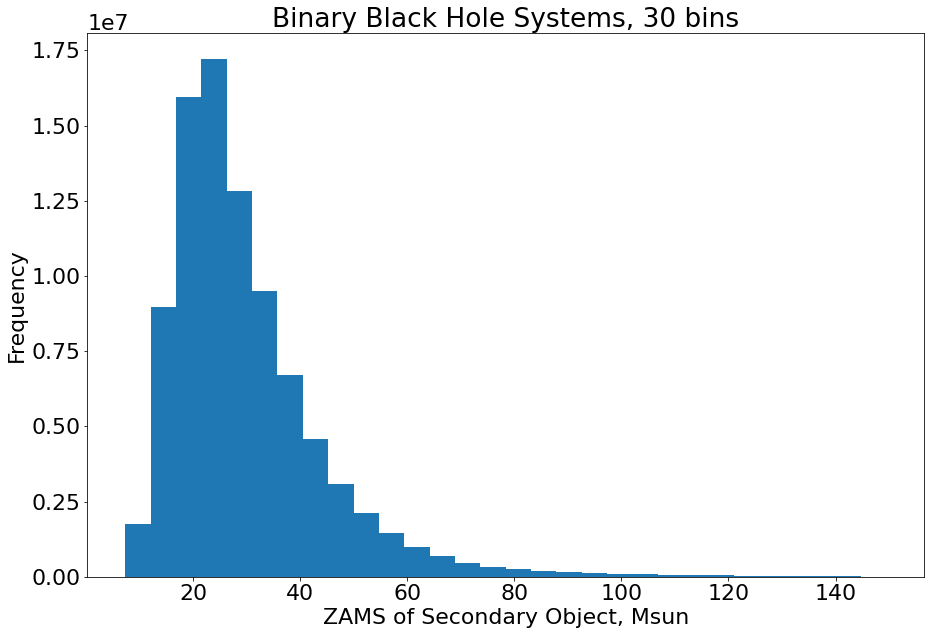

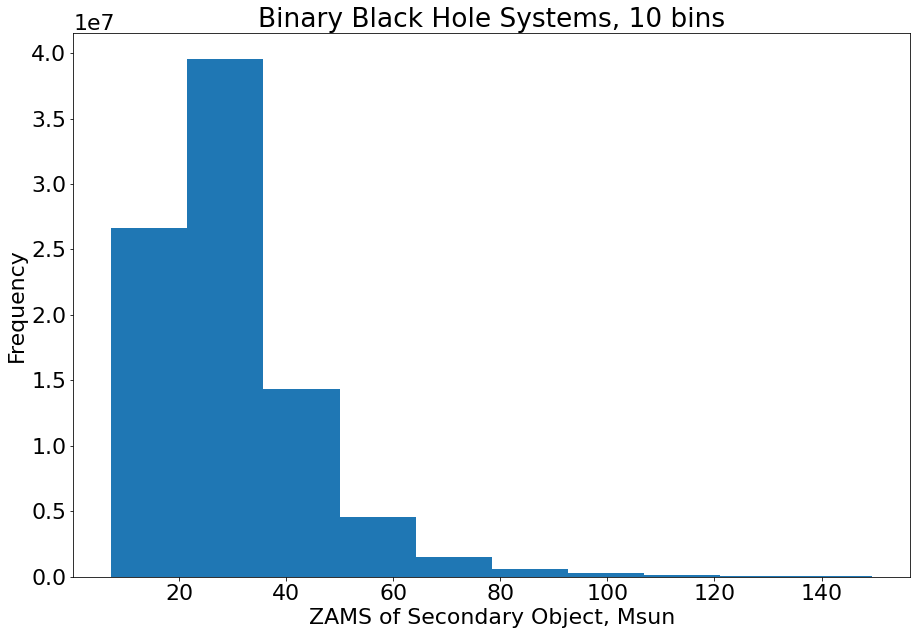

In [25]:
plotFrequency(df,'ZAMS of Secondary Object, Msun')

,"ZAMS of Secondary Object, Msun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(7.321, 13.006]",2.545067,0.749985,6.370268
1,"(13.006, 14.707]",2.282973,0.603554,6.093741
2,"(14.707, 16.037]",2.229506,0.573675,6.038900
3,"(16.037, 17.157]",2.185800,0.552109,5.978462
4,"(17.157, 18.144]",2.149412,0.531879,5.924269
5,"(18.144, 19.048]",2.098774,0.511739,5.855758
6,"(19.048, 19.891]",2.056208,0.492585,5.788369
7,"(19.891, 20.685]",2.001487,0.468577,5.707220
8,"(20.685, 21.449]",1.974401,0.457085,5.682730
9,"(21.449, 22.197]",1.947051,0.443681,5.634995


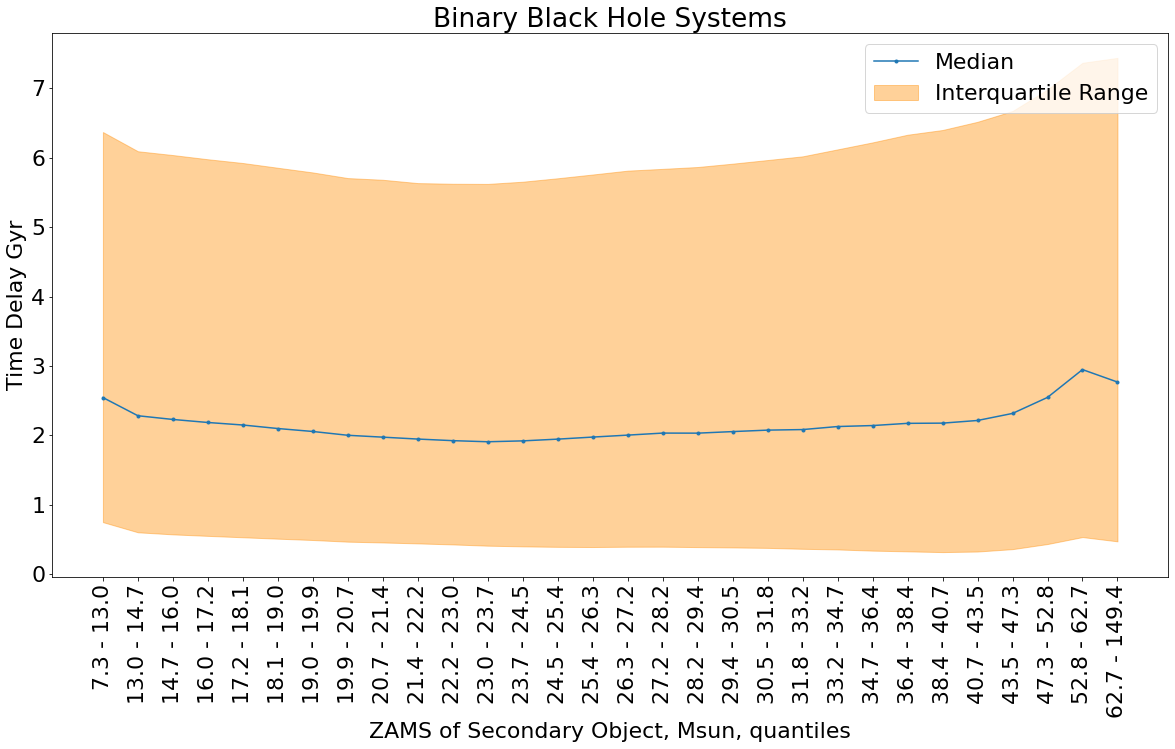

In [26]:
plotMedianMass(df,'ZAMS of Secondary Object, Msun')

# Mass of Primary Compact Object
In this case all compact objects are black holes. This is the mass of the object right before mergeing. The primary star should also remain the primary black hole.

In [27]:
df = getData(['m_comp_1','t_delay'])
df.columns = ['Mass of Primary Compact Object, Msun','t_delay']

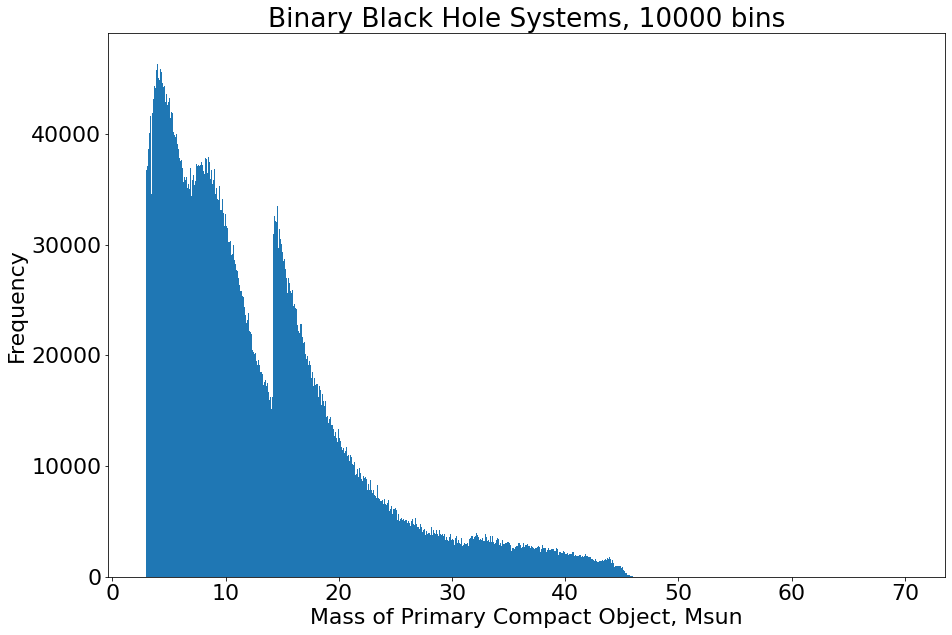

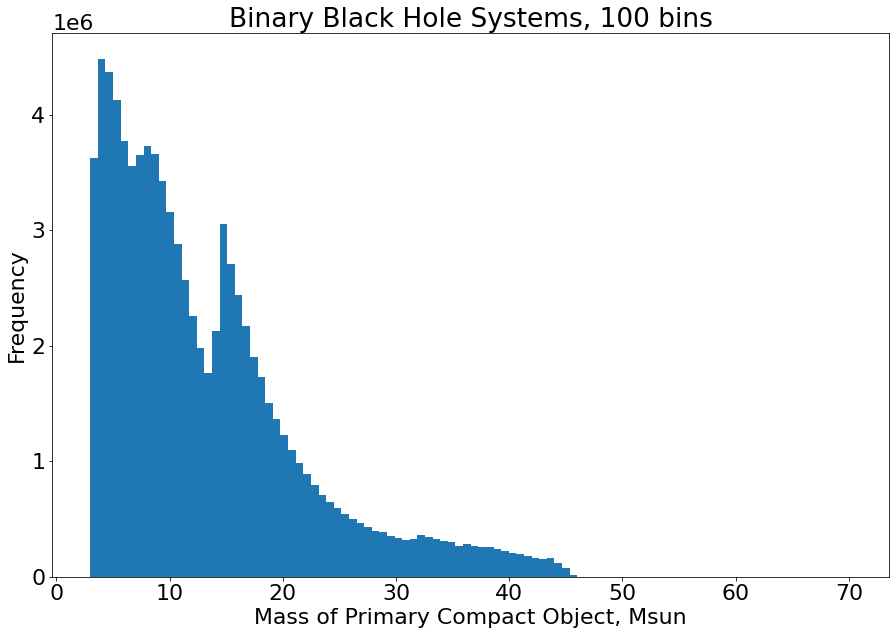

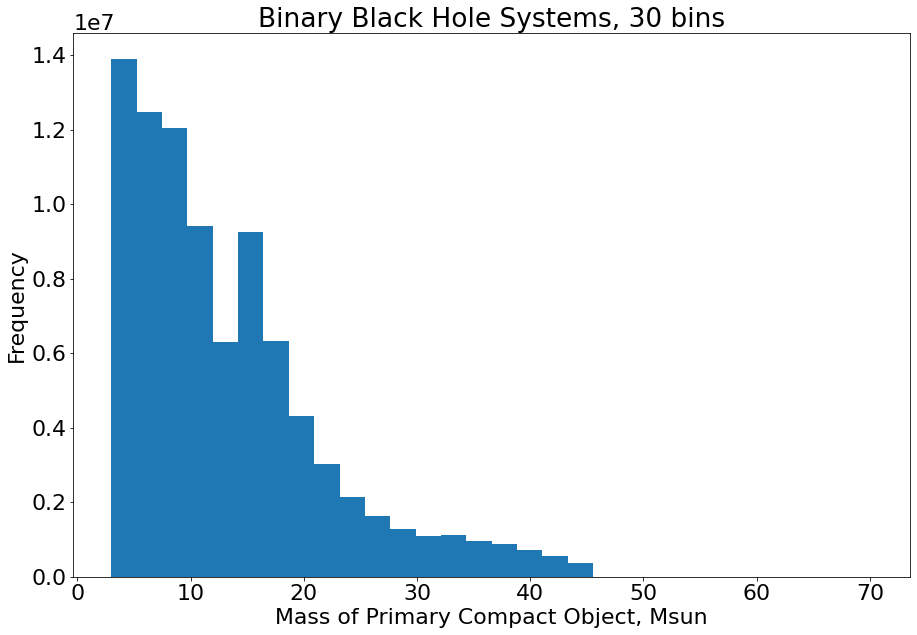

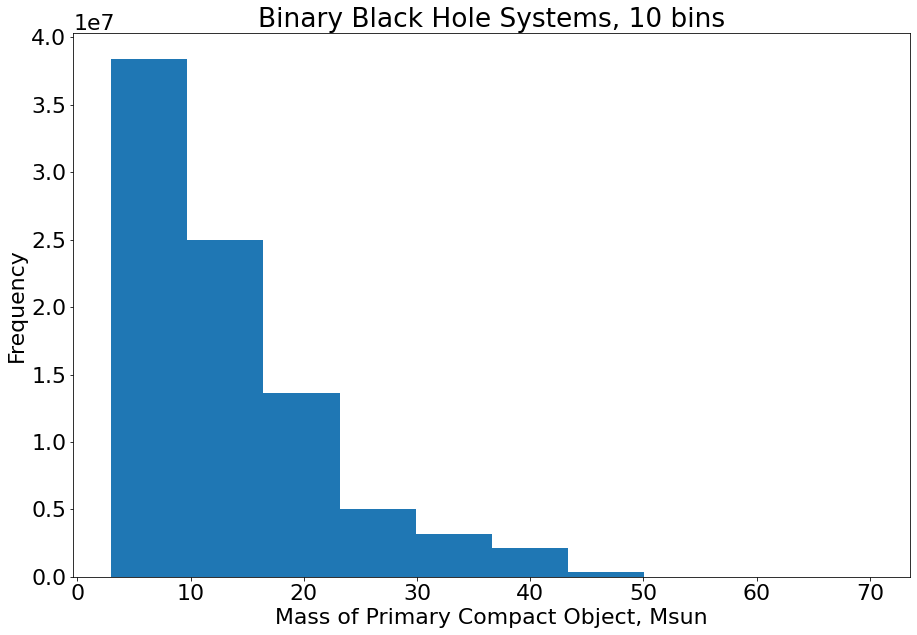

In [28]:
plotFrequency(df,'Mass of Primary Compact Object, Msun')

,"Mass of Primary Compact Object, Msun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(2.999, 3.564]",2.534658,0.802995,6.215223
1,"(3.564, 4.007]",2.461080,0.736153,6.186198
2,"(4.007, 4.445]",2.355057,0.665111,6.093496
3,"(4.445, 4.894]",2.272491,0.612669,6.013651
4,"(4.894, 5.36]",2.179773,0.561183,5.937073
5,"(5.36, 5.85]",2.092688,0.516630,5.868042
6,"(5.85, 6.379]",2.000510,0.472116,5.798245
7,"(6.379, 6.931]",1.920590,0.437457,5.697742
8,"(6.931, 7.476]",1.873174,0.419665,5.607530
9,"(7.476, 8.004]",1.794153,0.385406,5.458196


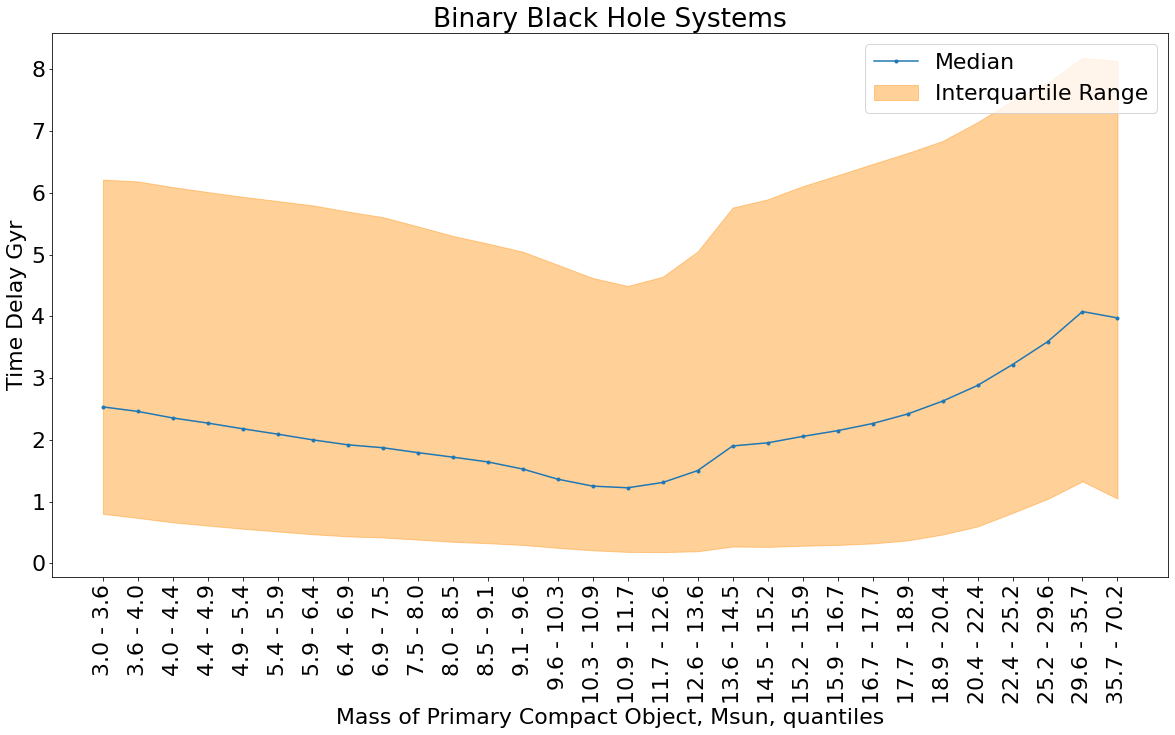

In [30]:
plotMedianMass(df,'Mass of Primary Compact Object, Msun')

# Mass of Secondary Compact Object

In [31]:
df = getData(['m_comp_2','t_delay'])
df.columns = ['Mass of Secondary Compact Object, Msun','t_delay']

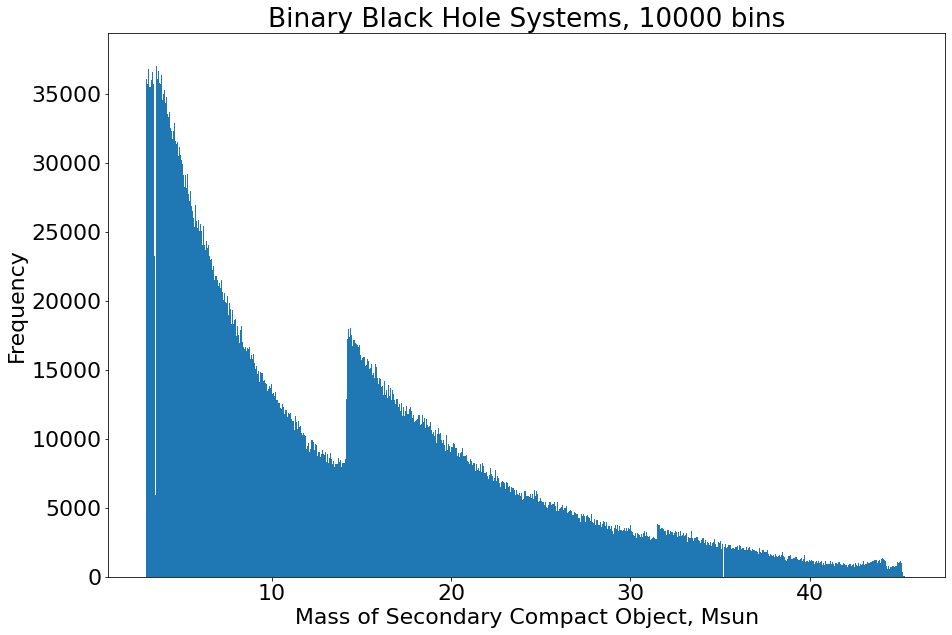

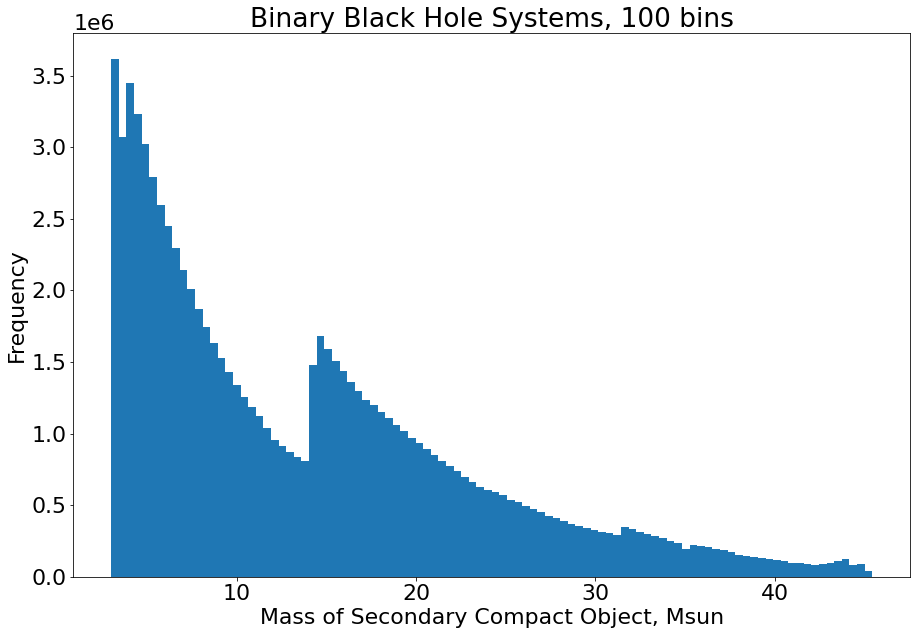

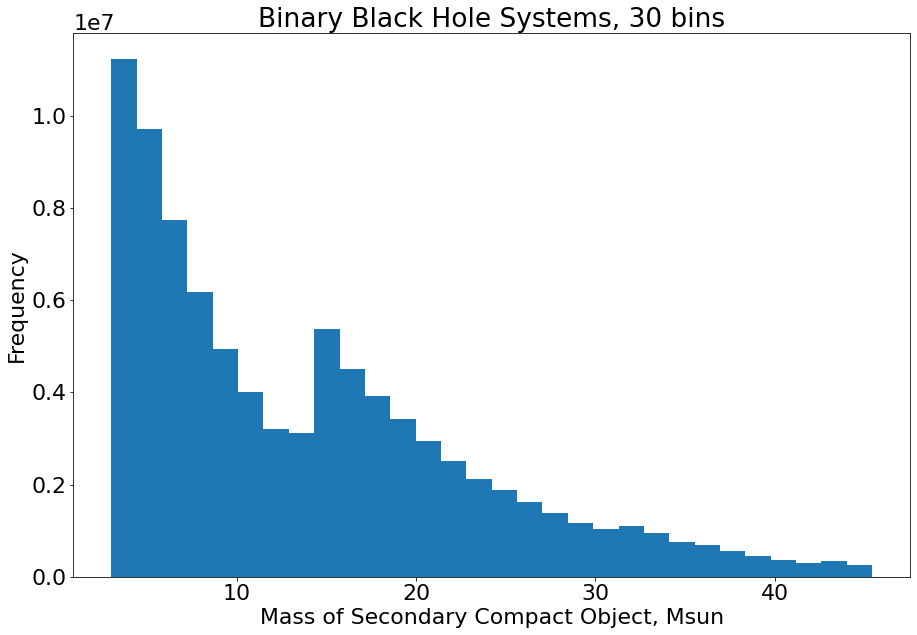

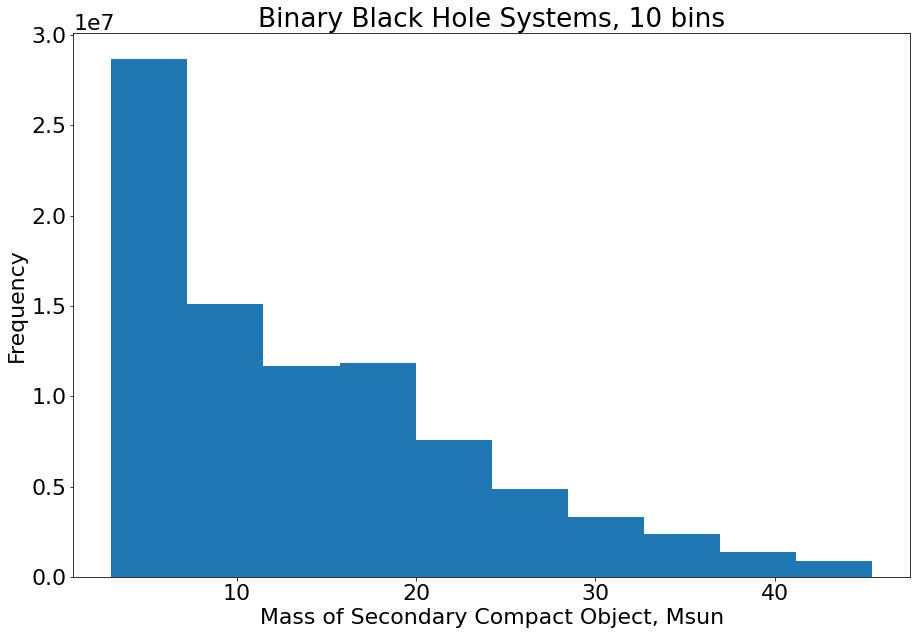

In [32]:
plotFrequency(df,'Mass of Secondary Compact Object, Msun')

,"Mass of Secondary Compact Object, Msun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(2.999, 3.342]",2.810534,0.868587,6.677646
1,"(3.342, 3.749]",2.619949,0.768652,6.484381
2,"(3.749, 4.103]",2.528571,0.741440,6.379838
3,"(4.103, 4.476]",2.423867,0.670211,6.239851
4,"(4.476, 4.87]",2.319701,0.606711,6.134978
5,"(4.87, 5.294]",2.246325,0.571466,6.057340
6,"(5.294, 5.754]",2.101842,0.513238,5.891119
7,"(5.754, 6.248]",1.967711,0.461222,5.728595
8,"(6.248, 6.78]",1.832349,0.411932,5.558254
9,"(6.78, 7.363]",1.712491,0.365517,5.394525


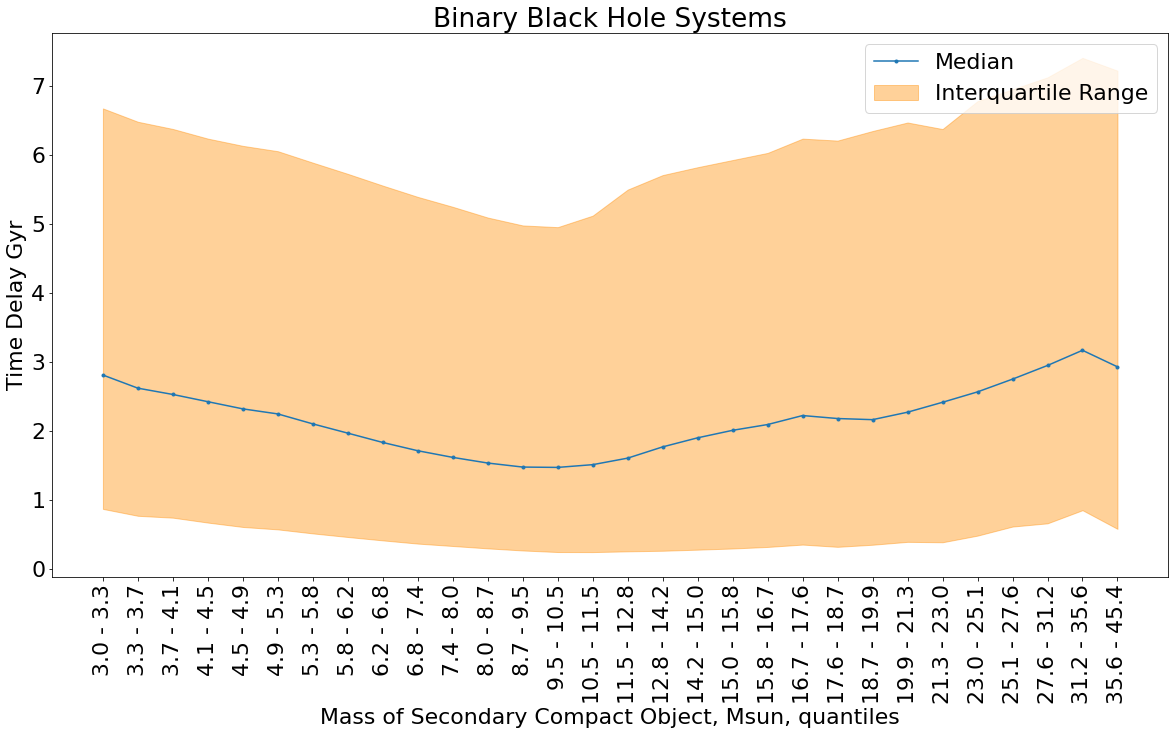

In [33]:
plotMedianMass(df,'Mass of Secondary Compact Object, Msun')

# Mass of Merged Object
This is the sum of the two compact masses. It is the mass of the remenant object that remains after the binary black holes merge together.

In [34]:
df = getData(['m_merge','t_delay'])
df.columns = ['Mass of Merged Object, Msun','t_delay']

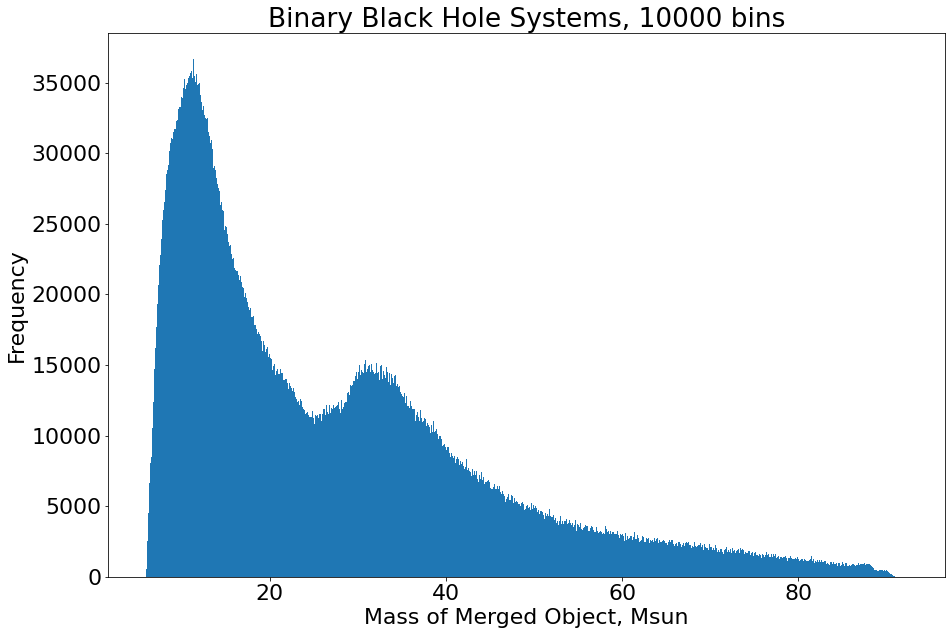

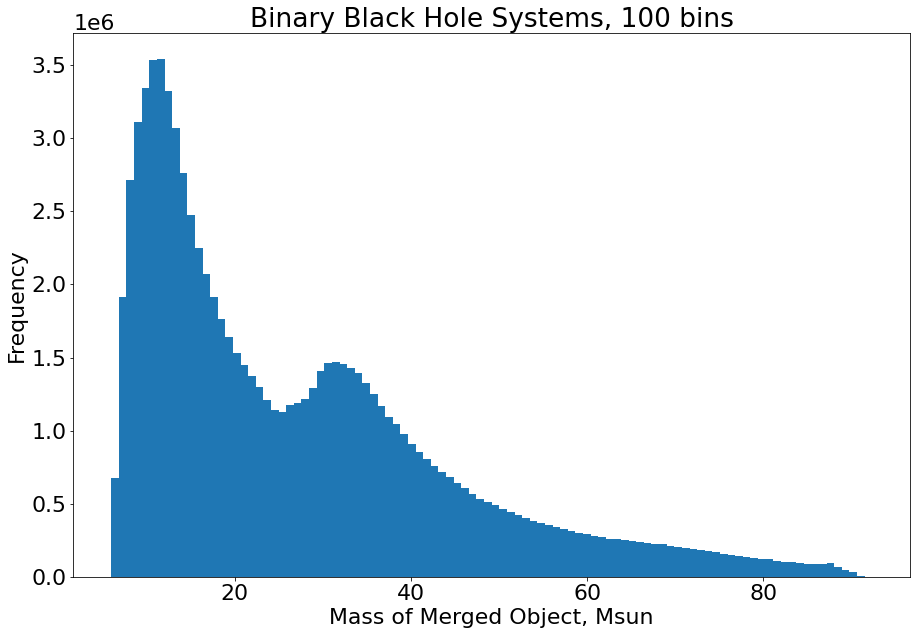

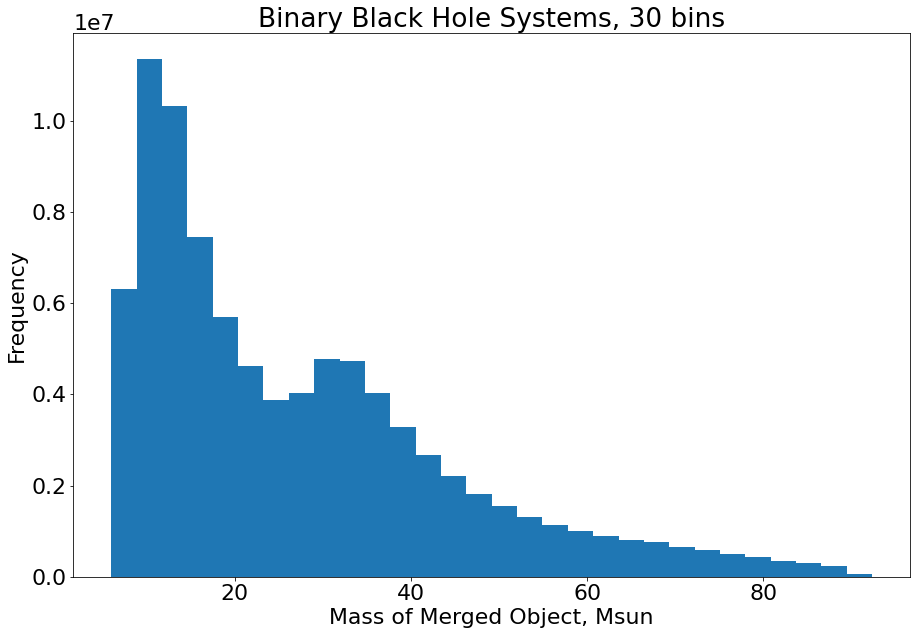

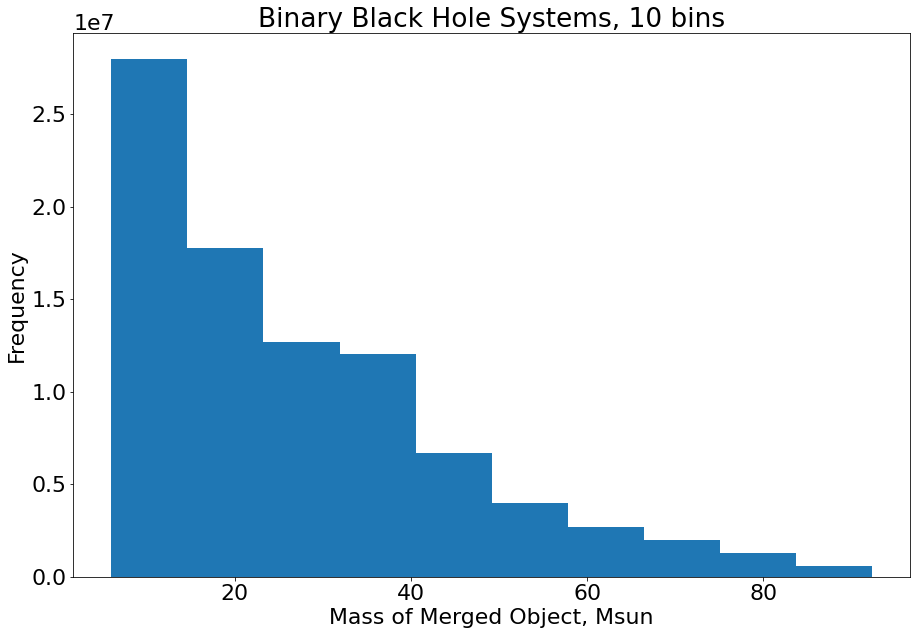

In [35]:
plotFrequency(df,'Mass of Merged Object, Msun')

,"Mass of Merged Object, Msun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(6.0009999999999994, 7.848]",3.260069,1.167658,7.095747
1,"(7.848, 8.75]",2.812112,0.899576,6.661954
2,"(8.75, 9.553]",2.557030,0.751271,6.379310
3,"(9.553, 10.306]",2.361982,0.653799,6.144033
4,"(10.306, 11.022]",2.200415,0.577239,5.937882
5,"(11.022, 11.731]",2.052316,0.507128,5.749776
6,"(11.731, 12.467]",1.941555,0.453704,5.612029
7,"(12.467, 13.249]",1.817019,0.397746,5.434770
8,"(13.249, 14.107]",1.734851,0.362313,5.337424
9,"(14.107, 15.07]",1.663080,0.345017,5.277527


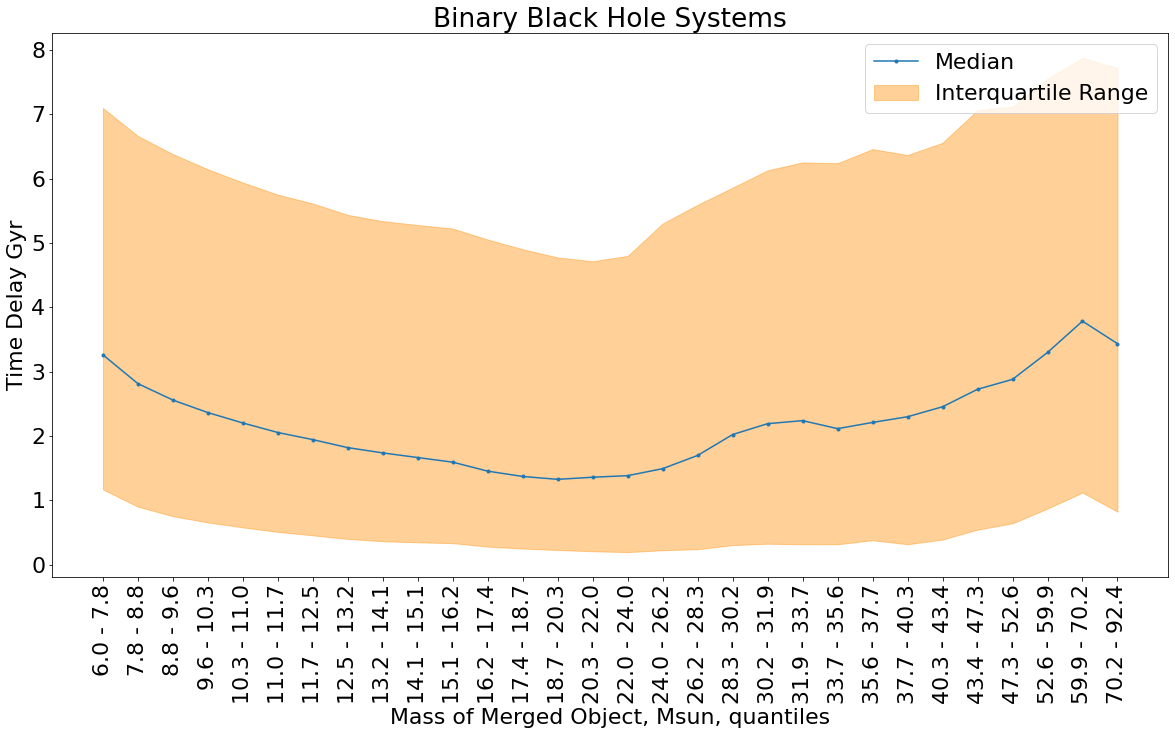

In [36]:
plotMedianMass(df,'Mass of Merged Object, Msun')

# Semi-Majour Axis
This is with regard to the objects eliptical orbit. It is the distance from the center of mass of the orbit to the farthest point of the orbit. The large this is the further the objects are apart when the binary star system is formed. The farther apart the objects are the longer it should take for them to merge and the time delay should be larger.

In [37]:
df = getData(['smj_axis','t_delay'])
prop = 'Semi Majour Axis, '+units['smj_axis']
df.columns = [prop,'t_delay']

,quantile,frequency
0,"(-0.0009323000000000001, 4.058]",2925483
1,"(4.058, 4.787]",2925313
2,"(4.787, 5.436]",2925301
3,"(5.436, 6.071]",2925195
4,"(6.071, 6.705]",2924860
5,"(6.705, 7.338]",2925563
6,"(7.338, 7.967]",2925138
7,"(7.967, 8.592]",2925300
8,"(8.592, 9.216]",2925132
9,"(9.216, 9.842]",2925390


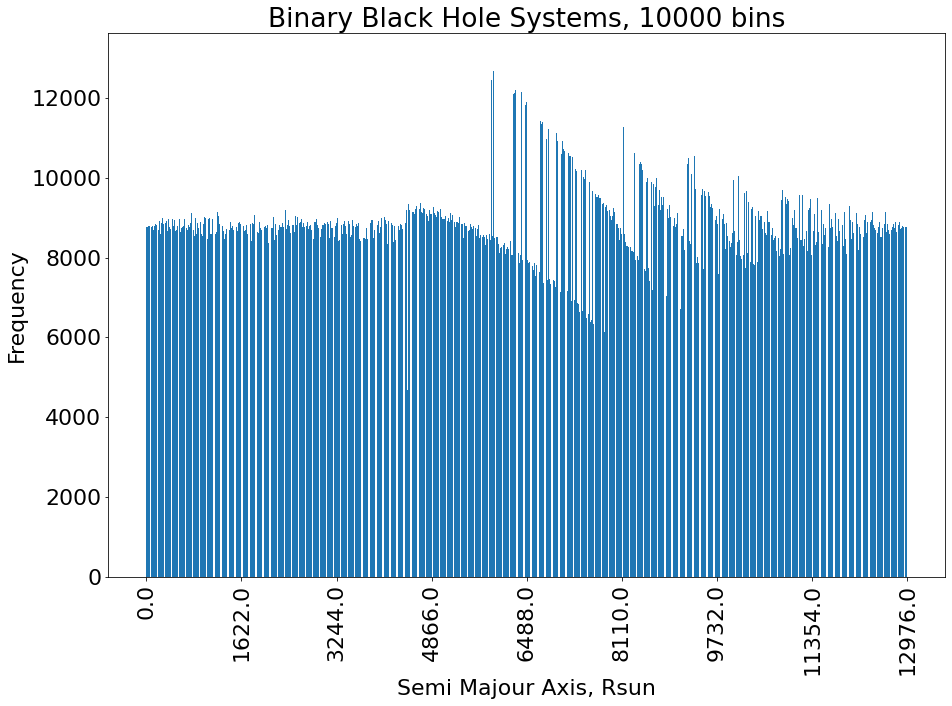

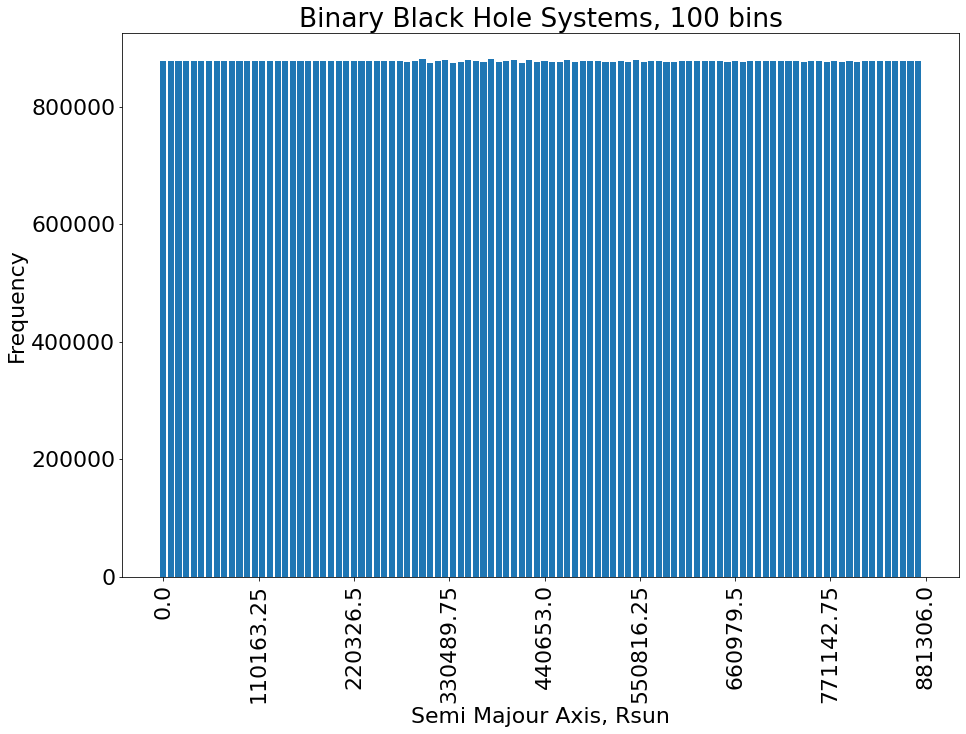

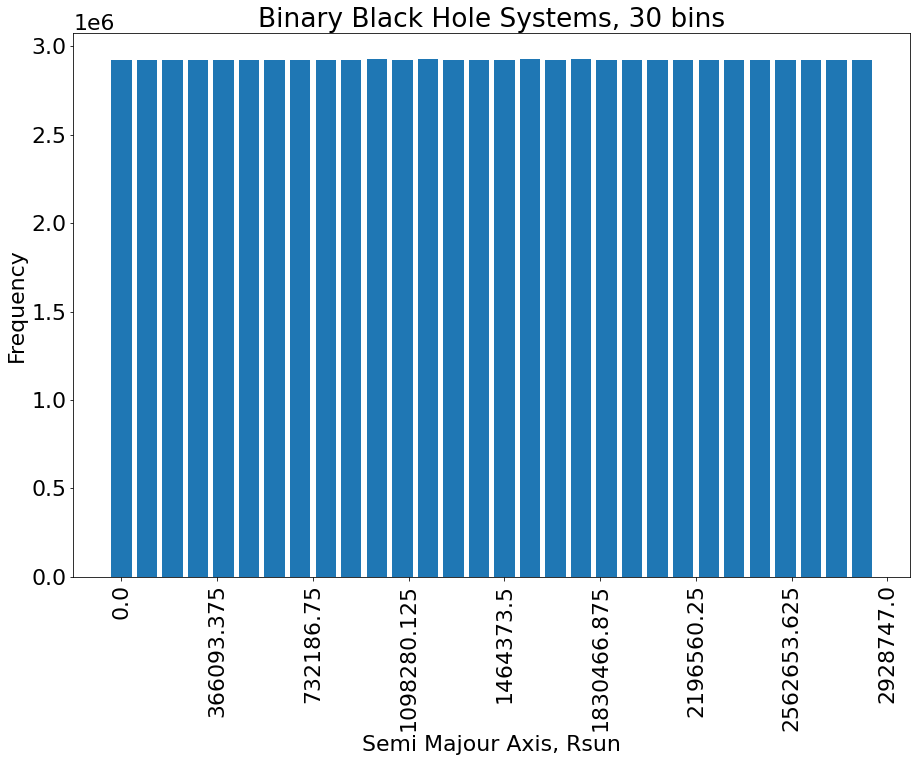

In [38]:
#plotFrequency(df,prop)
#plt.hist(df[prop])
def plotFrequency2(df,prop,nbins = 30):
    quantile, bins = pd.qcut(df[prop], q = nbins, retbins = True)
    df['quantile'] = quantile
    freq = df.groupby('quantile').agg('count').reset_index()
    freq = freq.iloc[:,0:2]
    freq.columns = ['quantile','frequency']

    #quantile, binsl = pd.qcut(df[prop], q = 8, retbins = True)
    xlabU = np.around(np.max(freq['frequency']),1)/8
    xlab = [xlabU*i for i in range(0,9)]

    figorbec = plt.figure()
    x = range(0,len(freq))
    xl = [len(freq)*i/8 for i in range(0,9)]
    plt.bar(x,freq['frequency'])
    plt.title('Binary Black Hole Systems, '+str(nbins)+' bins')
    plt.xticks(xl,xlab, rotation = 90)
    plt.xlabel(prop)
    plt.ylabel('Frequency')
    return freq

plotFrequency2(df,prop,nbins = 10000)
plotFrequency2(df,prop,nbins = 100)
plotFrequency2(df,prop,nbins = 30)

,"Semi Majour Axis, Rsun, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(-0.0009323000000000001, 4.058]",0.018161,0.012098,0.040932
1,"(4.058, 4.787]",0.060698,0.025390,0.122597
2,"(4.787, 5.436]",0.114019,0.045222,0.217015
3,"(5.436, 6.071]",0.188798,0.067810,0.349342
4,"(6.071, 6.705]",0.287246,0.100927,0.535949
5,"(6.705, 7.338]",0.412759,0.150114,0.784586
6,"(7.338, 7.967]",0.577457,0.219572,1.107153
7,"(7.967, 8.592]",0.781793,0.303714,1.514302
8,"(8.592, 9.216]",1.022346,0.401969,2.003521
9,"(9.216, 9.842]",1.309342,0.516278,2.568958


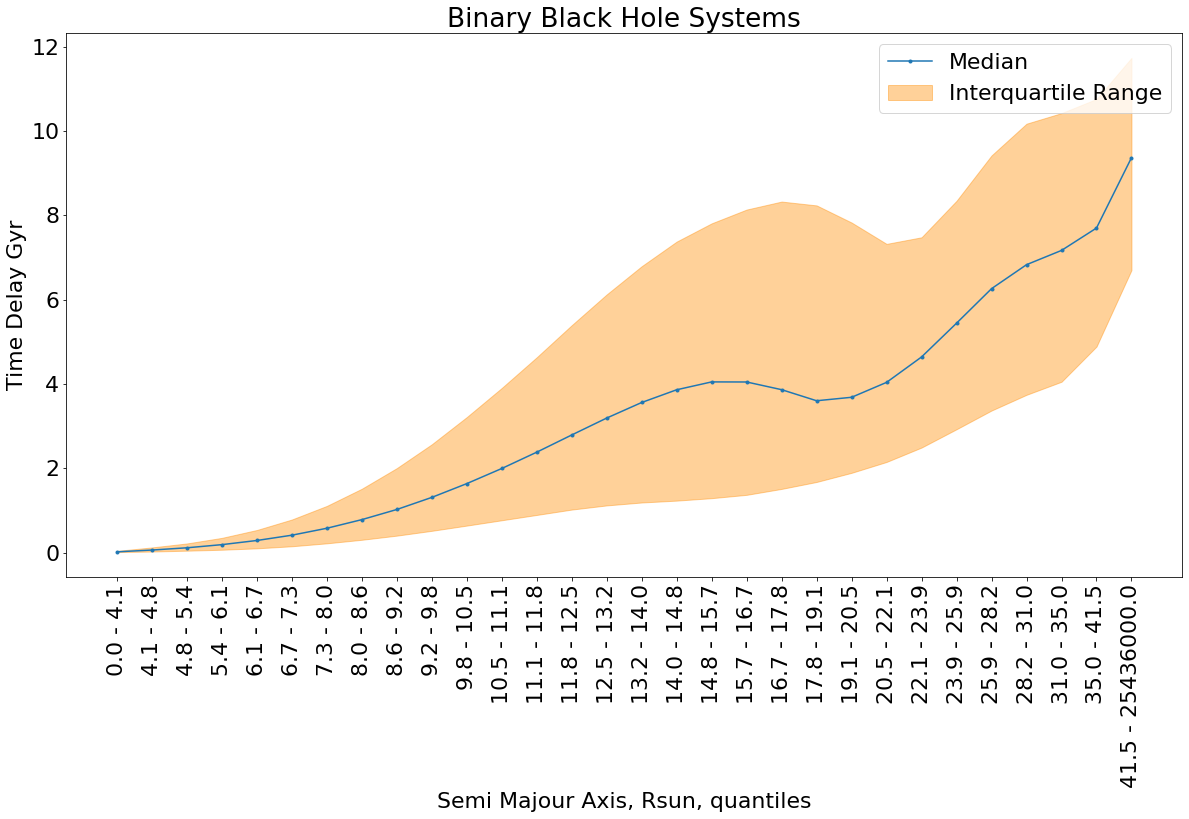

In [39]:
plotMedianMass(df,prop)

# Orbital Escentricity
This is a measure of how eliptical an orbit is. A value of 1 would be a straight line and a value of 0 would be a perfect circle.

In [40]:
df = getData(['orb_ecc','t_delay'])
df.columns = ['Orbital Escentricity','t_delay']

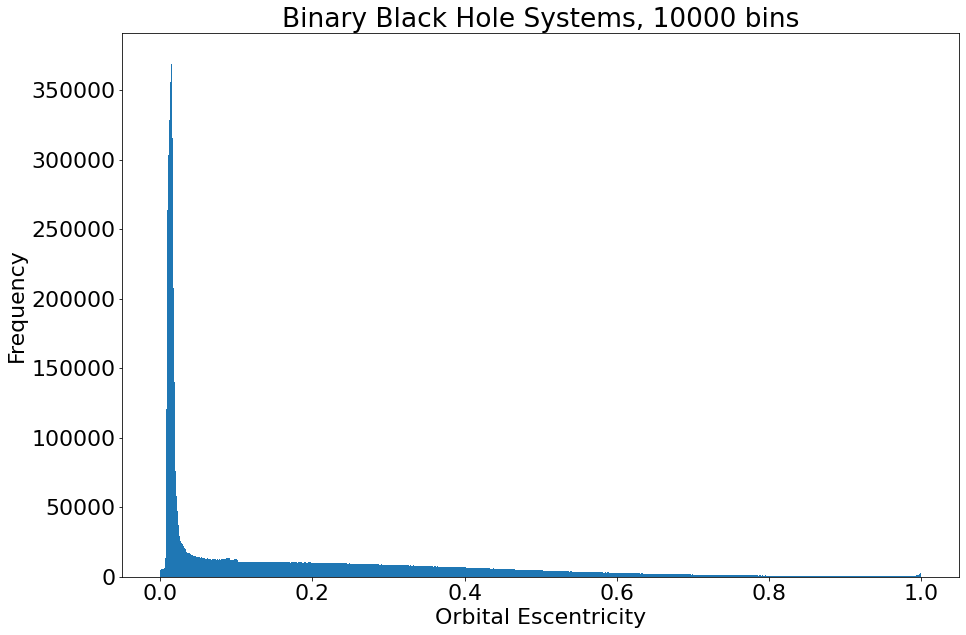

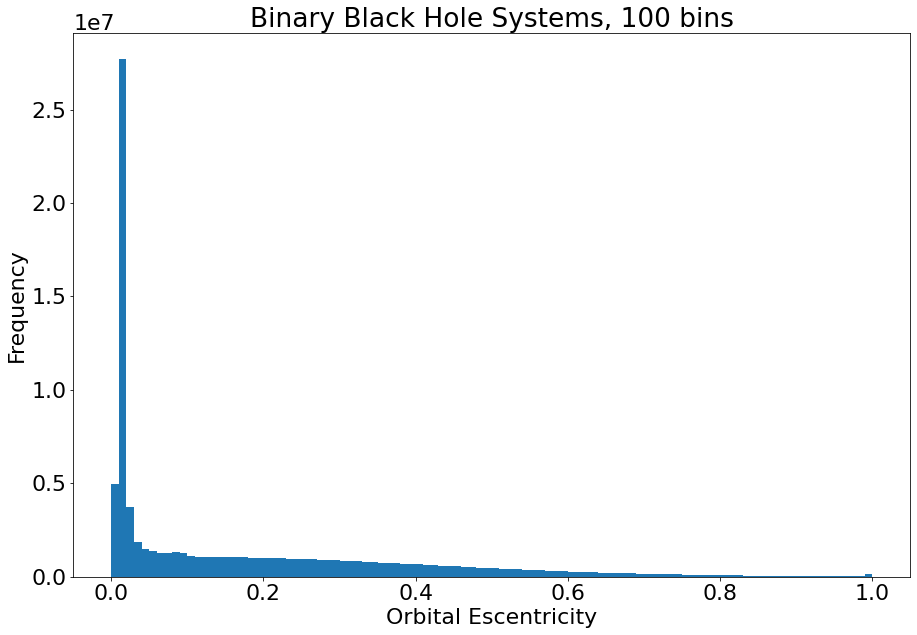

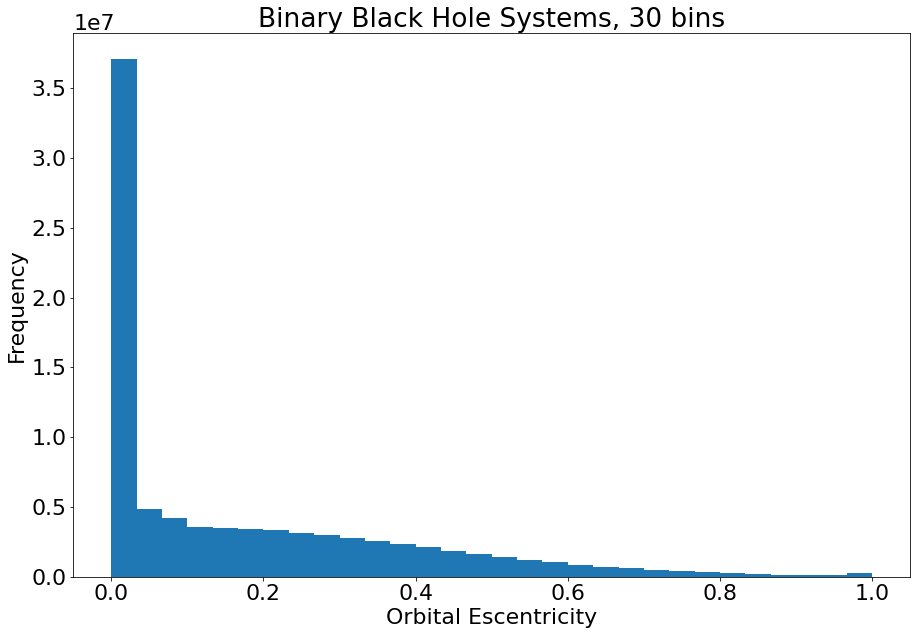

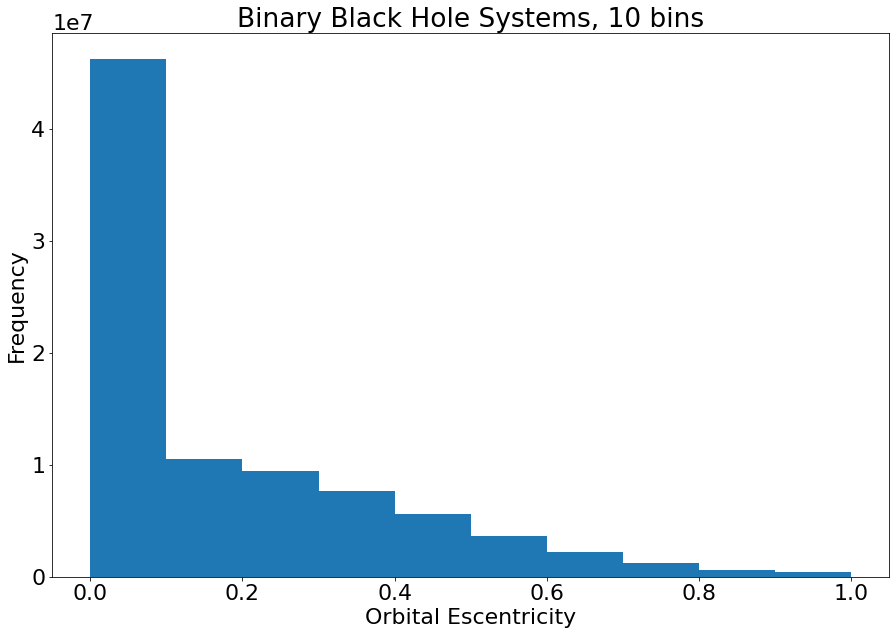

In [41]:
plotFrequency(df,'Orbital Escentricity')

,"Orbital Escentricity, quantiles",median_t_delay,lower_quartile,upper_quartile
0,"(-0.000999317, 0.00923]",4.214640,1.369717,8.320556
1,"(0.00923, 0.0103]",3.111603,0.729169,7.342313
2,"(0.0103, 0.0113]",2.885249,0.617659,7.161199
3,"(0.0113, 0.0122]",2.626335,0.455870,6.813080
4,"(0.0122, 0.0131]",2.461944,0.361474,6.500060
5,"(0.0131, 0.0139]",2.362367,0.422363,6.649224
6,"(0.0139, 0.0147]",2.258993,0.354205,6.430055
7,"(0.0147, 0.0155]",2.360220,0.341992,6.436102
8,"(0.0155, 0.0164]",2.334041,0.373556,6.278313
9,"(0.0164, 0.0175]",1.928030,0.298084,5.557247


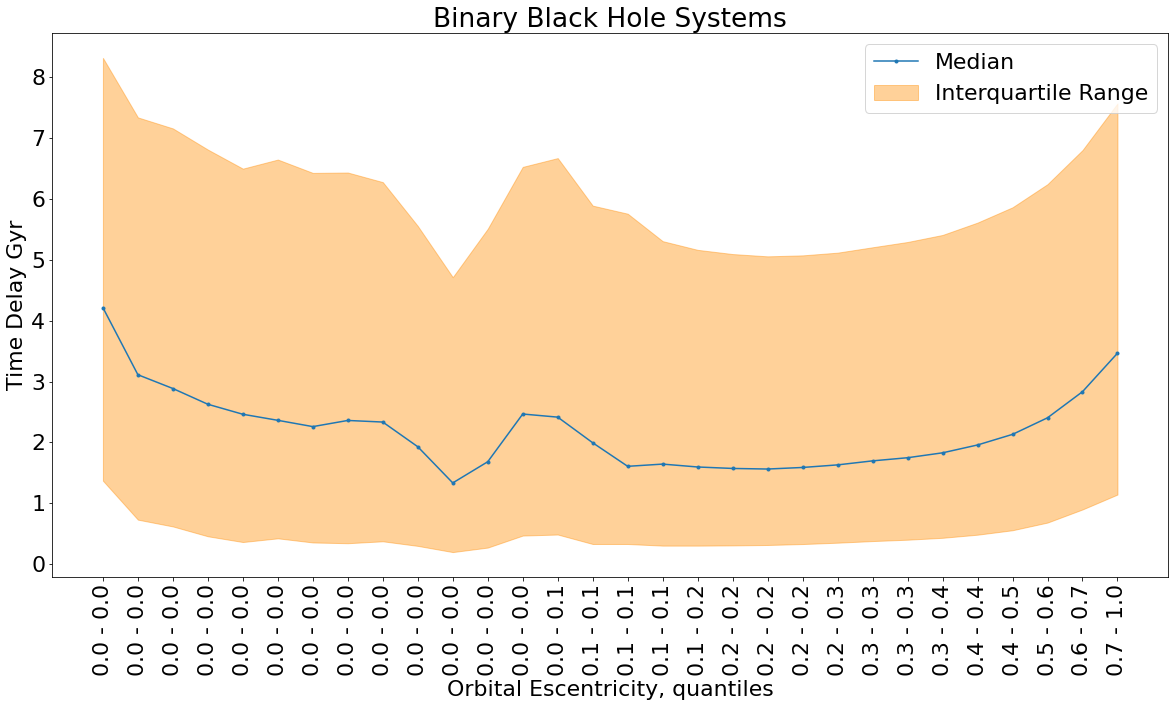

In [42]:
plotMedianMass(df,'Orbital Escentricity')